In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 2.0 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 43.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 78.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 68.6 MB/s eta 0:00:01
     |████████████████████████████████| 203 kB 77.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 47.8 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 51.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 86.7 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 66.8 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 8.2 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 8.1 MB/s  eta 0:00:01
     |████████████████████████████████|

In [1]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys

In [566]:
%cd /app/yolov5 

/app/yolov5


In [568]:
from utils.plots import  plot_evolve

In [570]:
plot_evolve(evolve_csv="./runs/evolve/exp14/evolve.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/evolve.csv'

In [2]:
def set_dicom_path(dicom_path):
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_path +'\n')
    f.write('warn = True')
    f.close()

In [3]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [4]:
def find_all_bboxes(nodule_annotation, nodule_id, plot=False):
    bboxes = []
    #cmask, cbbox, masks = consensus(nodule_annotation)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        

    print("There are {} slices in the image".format(cbbox_CT[nodule_id][2].stop - cbbox_CT[nodule_id][2].start))
    for idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,idx])
        if plot:
            plot_bounding_box(CT_mask[:,:,idx])
        bboxes.append(boxes)
    return bboxes

In [5]:
def plot_bbox_on_full_size_mask(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        plot_bounding_box(CT_mask[:,:,slice_idx])

In [6]:
def plot_bbox_on_image(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,slice_idx])
        img = vol[:,:,slice_idx]
        fig, ax = plt.subplots()
        ax.imshow(img, cmap=plt.cm.gray)
        if boxes:
            for box in boxes:
                x, y, w, h = box
                print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

In [7]:
import shutil
def clear_dirs(paths):
    for path in paths:
        if os.path.isdir(path):
            shutil.rmtree(path)

In [8]:
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

In [9]:
def un(a, b):
    return np.union1d(a, b)

def unr(ll, acc, i):
    if i < len(ll):
        j = i + 1
        acc = un(ll[i], acc)
        return unr(ll, acc, j)
    else:
        return acc

def get_slices_with_masks(cbbox_CT):
    ll = []
    for cb in cbbox_CT:
        ll.append(np.arange(cb[2].start, cb[2].stop+1))
    return unr(ll, [], 0)

In [10]:

#patient_id = patient_list_test[0]

def load_patient_vol_and_mask(dicom_dir, patient_id=-1):
    
    devnull = open(os.devnull, 'w')
    
    
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_dir +'\n')
    f.write('warn = True')
    f.close()
    
    patient_list = os.listdir(dicom_dir)
    if patient_id == -1: #select one randomly
        patient_id = np.random.choice(patient_list)
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    vol = None
    try:
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            vol = scan.to_volume()
    except:
        print("Error loading DICOM for patient {}".format(patient_id))
        return None, None, None, None
    # are there nodules that are useful?

    # process the mask for the image
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        if len(nodule) >= 4:
            cmask, cbbox, masks = consensus(nodule)
            cmask_CT.append(cmask)
            cbbox_CT.append(cbbox)
            masks_CT.append(masks)

    if len(cbbox_CT) <=0:
        #print("No relevant nodules for patient {}".format(patient_id))
        return None, None, None, None


    # create the mask voxel
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    #print("Number of nodules {}".format(nodule_num))
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask

    # get the slices that have annotations
    slices_with_mask = get_slices_with_masks(cbbox_CT)
    
    return vol, CT_mask, cbbox_CT, slices_with_mask

In [11]:
def plot_side_by_side(vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[:,:,idx])
    a[1].imshow(mask[:,:,idx])
    plt.show()

# get 8 pixels along all axes
def plot_side_by_side_cropped(cbbox, vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    a[1].imshow(mask[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    plt.show()

### UNET data augmentation

- With slight changes to the cropping strategy of the image, the prediction radically changes
- We need to have a better data augmentation for the model training, the random image generation with nodule does not seem to be doing a good job

In [12]:
import cv2
from pathlib import Path
import random
import math

In [13]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [14]:
def resize_image(read_path,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    #new_path = str(write_path/read_path.parts[-1])
    #cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return im_resized

In [15]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def random_cropXY(x, Y, r_pix=8, cnt=3):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    lrand_r = np.random.uniform(0, 1, cnt)
    lrand_c = np.random.uniform(0, 1, cnt)
    xxs = []
    YYS = []
    for rand_r, rand_c in zip(lrand_r, lrand_c):
        start_r = np.floor(2*rand_r*r_pix).astype(int)
        start_c = np.floor(2*rand_c*c_pix).astype(int)
        xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
        YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
        xxs.append(xx)
        YYS.append(YY)
    return xxs, YYS

#### Generate data for Unet

- Select patients from the dicom dir
- for each patient, load the volumes and masks
    - Choose only those nodules that are annotated by more than 4 radiologists
    - Select only those slices from the DICOM image which has annotated masks
    - For each of those slices, extract a cropped 64x64 image around the mask with the annotated bounding box in the center
    - Also generate at least one 64x64 image with the center randomly chosen in the annotated bounding box

In [16]:
# take 32 pixels including c_x on each axis
def get_stride(c, size=32):
    start = 0
    if (c - size) > 0:
        start = c - size
    else:
        start = 0
    if (c + size) < 512:
        stop = c + size
    else:
        stop = size
    return slice(start, stop, None)

"""
    Get a 64x64 image around the nodule, when using random = false, we get the actual clip of the annotated nodule,
    when using random = true, get a 64x64 image around the nodule randomly chosen which may or may not show a part of the nodule
"""
def get_nodule_part(cbbox, random=False, shape=(32, 32)):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x, shape[0]), get_stride(c_y, shape[1]), cbbox[2]

"""
    Get a 64x64 image just outside the nodule bounding box 
"""
def get_outside_part(cbbox, random=False):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x, shape[0]), get_stride(c_y, shape[0]), cbbox[2]

In [17]:
def in_box(coord):
    return (coord[0] + 32 < 512) and (coord[0] - 32 > 0) and (coord[1] + 32 < 512) and (coord[1] - 32 > 0)

"""
    Takes multiple bounding boxes and returns slices for each of them, converts box to slice
    sample data: boxes = [(285.5, 280.5, 6.0, 5.0)]
"""
def get_slices(boxes, flipxy=True):
    slices = []
    for box in boxes:
        if flipxy:
            x = int(box[1])
            w = x + int(box[2])
            y = int(box[0])
            h = y + int(box[3])
            slices.append((slice(x, w, None), slice(y, h, None)))
        else:
            x = int(box[0])
            w = x + int(box[2])
            y = int(box[1])
            h = y + int(box[3])
            # slices.append((slice(x, w, None), slice(y, h, None)))
            # add 1 pixel margin to handle issues due to float values flooring from box
            slices.append((slice(y-1, h+1, None), slice(x-1, w+1, None)))
    return slices


# get boxes outside of this slice, get a 64x64 box just outside these slices
def get_all_box_centers(slices, shift, outside_margin=32):
    coords_l = []
    coords_r = []
    coords_t = []
    coords_b = []
    for slc in slices:
        xslc = slc[1]
        yslc = slc[0]
        y = int(yslc.start + (yslc.stop - yslc.start)/2)
        x = int(xslc.start + (xslc.stop - xslc.start)/2)
        coords_l.extend([a for a in zip(np.repeat(xslc.start - shift, (yslc.stop+outside_margin) - (yslc.start-outside_margin)), 
                                      np.arange(yslc.start - outside_margin, yslc.stop + outside_margin))])
        coords_r.extend([a for a in zip(np.repeat(xslc.stop + shift, (yslc.stop+outside_margin) - (yslc.start-outside_margin)), 
                                      np.arange(yslc.start- outside_margin, yslc.stop + outside_margin))])
        coords_t.extend([a for a in zip(np.arange(xslc.start-outside_margin, xslc.stop+outside_margin), 
                                      np.repeat(yslc.stop + shift, (xslc.stop+outside_margin)-(xslc.start-outside_margin)))])
        coords_b.extend([a for a in zip(np.arange(xslc.start-outside_margin, xslc.stop+outside_margin), 
                                      np.repeat(yslc.start - shift, (xslc.stop+outside_margin)-(xslc.start-outside_margin)))])
        coordsl = [crd for crd in coords_l if in_box(crd)]
        coordsr = [crd for crd in coords_r if in_box(crd)]
        coordst = [crd for crd in coords_t if in_box(crd)]
        coordsb = [crd for crd in coords_b if in_box(crd)]
    return (coordsl, coordsr, coordst, coordsb)

"""
    coords: tuple
"""
def get_random_slices(coords, num_select=12):
    coordsl, coordsr, coordst, coordsb = coords
    slices = []
    
    accum = 0
    
    if len(coordsl) > 0:
        idxs = np.random.choice(np.arange(len(coordsl)), int(num_select/4))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordsl[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
        
    if len(coordsr) > 0:
        idxs = np.random.choice(np.arange(len(coordsr)), int((num_select-accum)/3))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordsr[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
        
    if len(coordst) > 0:
        idxs = np.random.choice(np.arange(len(coordst)), int((num_select-accum)/2))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordst[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
        
    if len(coordsb) > 0:
        idxs = np.random.choice(np.arange(len(coordsb)), int((num_select-accum)/1))
        accum += len(idxs)
        for idx in idxs:
            x, y = coordsb[idx]
            #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
            slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
            
    return slices

In [18]:
"""
    Save cropped images from source such that none of them contain visible nodule, the images are cropped from around the nodule bounding box
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    num_random_images = number of random crop images to generate around the nodule
"""
def save_surrounding_images(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                            image_save=False, image_plot=True, num_random_images=12):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    voxel = CT_mask[:,:,bounding_box[nodule_number][2]]
    img_voxel = vol[:,:,bounding_box[nodule_number][2]]
    out_masks = []
    out_images = []
    out_slices = None
    for slice_id in range(voxel.shape[2]):
        boxes = get_bounding_box(voxel[:,:,slice_id])
        if boxes is None:
            #print("No bounding box for {} and slice {}".format(patient_id, slice_id))
            continue
        slices = get_slices(boxes, False)
        # use a margin of 2 pixels to adjust for the mask pixels in the boundary
        coords = get_all_box_centers(slices, 32+2, 32)
        out_slices = get_random_slices(coords, num_random_images) # get num_random_images random 64x64 images randomly from the image that does not show the mask (i.e., negative samples)
        out_slices = [out_slice + (bounding_box[nodule_number][2],) for out_slice in out_slices]
        for out_slice in out_slices:
            out_masks.append(voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
            out_images.append(img_voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
    
    b = []
    for a1 in unique_slice_ids:
        b.extend(np.repeat(a1, num_random_images))
    for idx, (unique_slice_id, mask)in enumerate(zip(b, out_masks)):
        img = out_images[idx]
        mask = out_masks[idx]
        if img.shape != (64, 64):
            continue
        if mask.shape != (64, 64):
            continue
        if len(np.unique(mask)) > 1:
            continue
        if image_save:
                image_file_name = "img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id)
                mask_file_name = "mask_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, img)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):    
                    imageio.imwrite(mask_dir + mask_file_name, mask)
        if image_plot:
            f, a =  plt.subplots(1,2, figsize=(8,10))
            a[0].imshow(img)
            a[0].set_title("img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id))
            a[1].imshow(mask)
            plt.show()

### Show data generation strategy for the segmentation model

In [103]:
### DEBUG:
#vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0284')
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')

In [140]:
#load a pretrained brain segmentation model and apply it to the dataset
brain_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


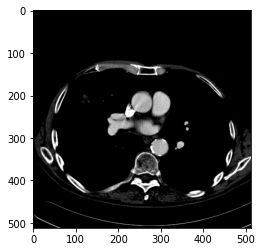

In [155]:
img = Image.fromarray(vol[:,:,cbbox[0][2]][:,:,2]).convert('RGB')
plt.imshow(img)

In [159]:
img1 = np.array(img)
img1.shape

(512, 512, 3)

In [161]:
img1[np.newaxis,:,:,:].shape

(1, 512, 512, 3)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


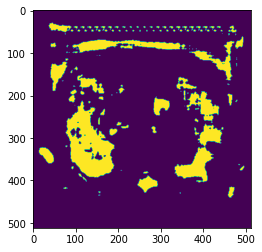

In [141]:
from torchvision import transforms
# the model needs a 3 channel input image
input_image = Image.fromarray(vol[:,:,cbbox[0][2]][:,:,2]).convert('RGB')
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = brain_model.to('cuda')

with torch.no_grad():
    output = brain_model(input_batch)

print(torch.round(output[0]))
plt.imshow(torch.round(output[0]).detach().cpu()[0,:,:])

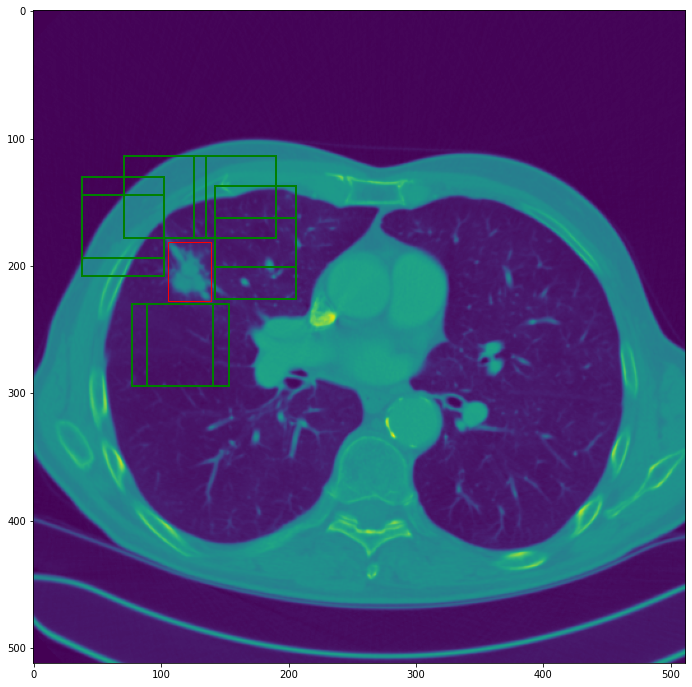

In [104]:
#### Draw outside points and boxes in mask
num_random_images = 8
fig, ax = plt.subplots(figsize=(14,12))
#ax.imshow(vol[:,:,cbbox[0][2]][:,:,2])
ax.imshow(vol[:,:,cbbox[0][2]][:,:,2])
boxes = get_bounding_box(CT_mask[:,:,cbbox[0][2]][:,:,2])
slices = get_slices(boxes, False)
coords = get_all_box_centers(slices, 32+2, 32)
out_slices = get_random_slices(coords, num_random_images)
#slice to bounding box
out_boxes = [(slcy.start, slcx.start, slcy.stop-slcy.start, slcx.stop-slcx.start) for slcx, slcy in out_slices]
if boxes:
    for box in boxes:
        x,y,w,h = box
        #print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
if out_boxes:
    for box in out_boxes:
        x,y,w,h = box
        #print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
# for x,y in coords:
#     ax.plot(x, y, marker="o")

In [111]:
out_slices

[(slice(130, 194, None), slice(38, 102, None)),
 (slice(144, 208, None), slice(38, 102, None)),
 (slice(162, 226, None), slice(142, 206, None)),
 (slice(137, 201, None), slice(142, 206, None)),
 (slice(230, 294, None), slice(89, 153, None)),
 (slice(230, 294, None), slice(77, 141, None)),
 (slice(114, 178, None), slice(126, 190, None)),
 (slice(114, 178, None), slice(71, 135, None))]

In [116]:
voxel = vol[:,:,cbbox[0][2]]#[out_slices[0]]
voxel

array([[[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [ -996, -1003, -1007, ..., -1000,  -995,  -998],
        [ -998,  -996, -1001, ...,  -997, -1001, -1003],
        [-1002,  -993,  -995, ...,  -999, -1000,  -998]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [ -994,  -999, -1002, ...,  -993,  -996, -1001],
        [-1000,  -993,  -989, ...,  -994, -1003, -1005],
        [-1003,  -994,  -988, ..., -1000,  -999,  -989]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [ -991,  -993,  -996, ...,  -996, -1000, -1007],
        [ -998,  -988,  -985, ..., -1000, -10

Loading dicom files ... This may take a moment.
There are 2 nodules


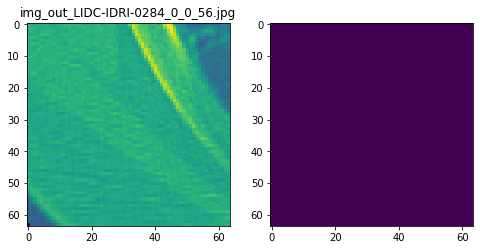

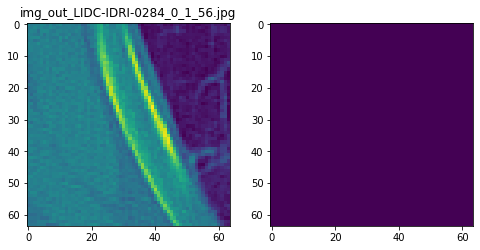

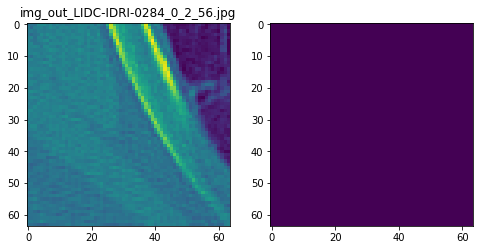

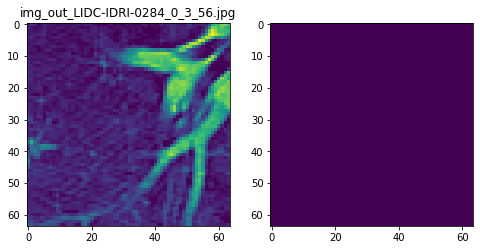

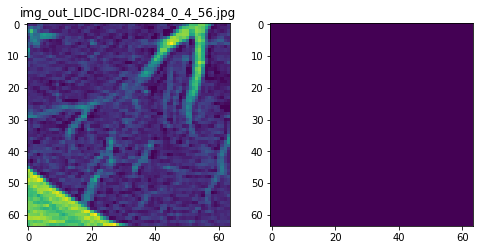

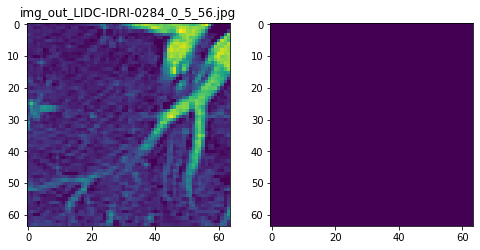

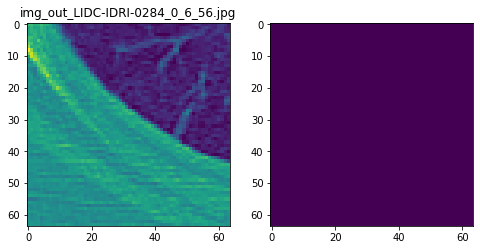

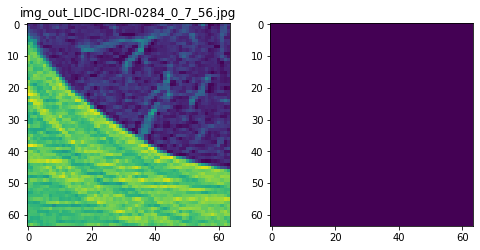

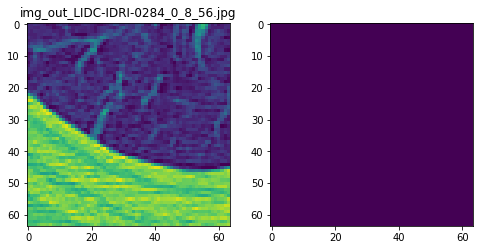

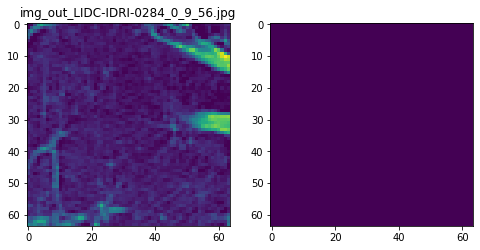

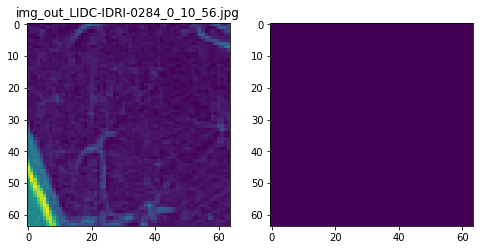

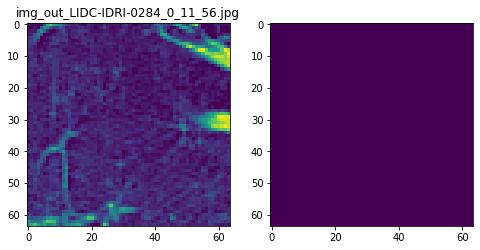

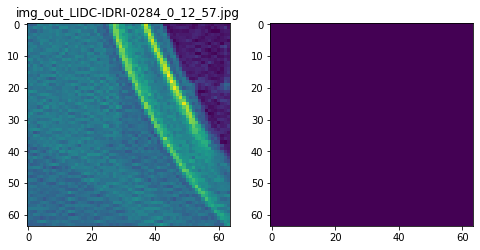

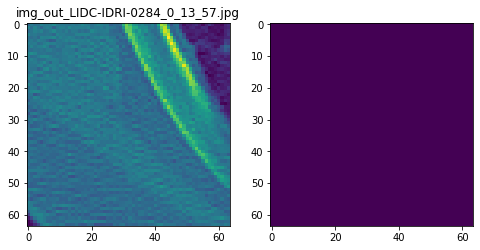

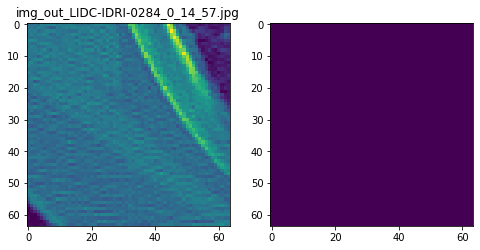

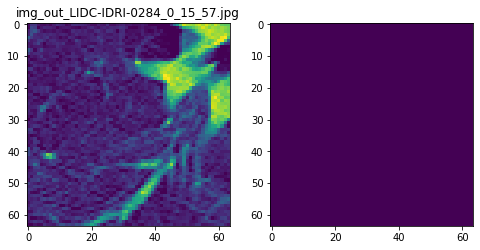

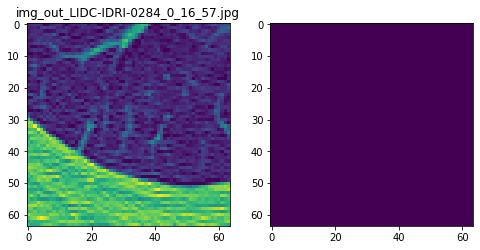

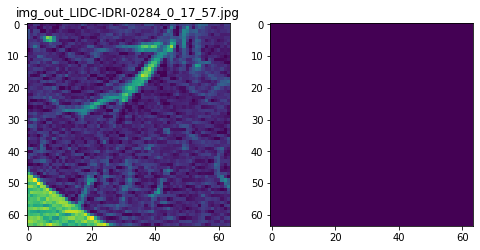

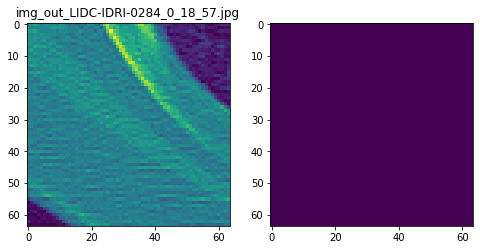

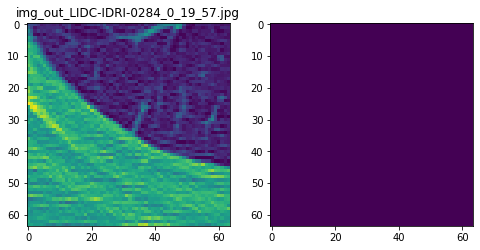

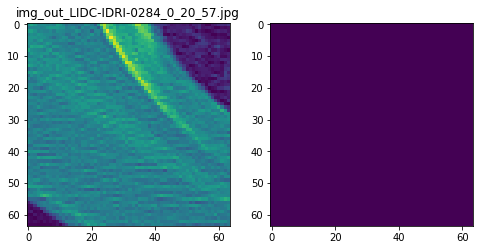

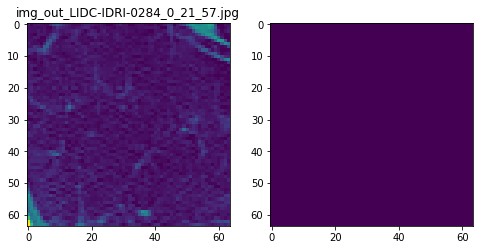

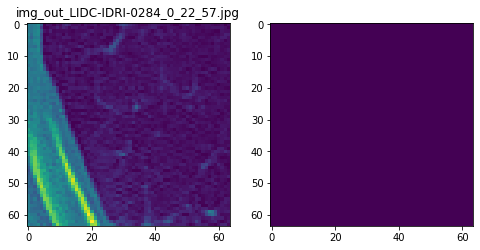

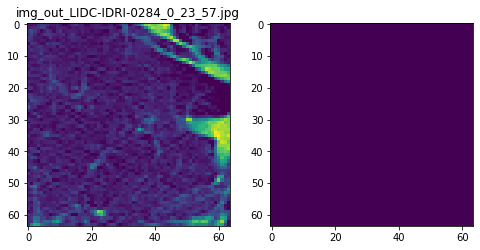

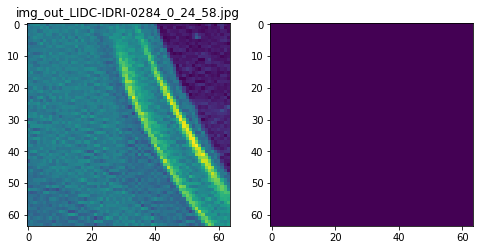

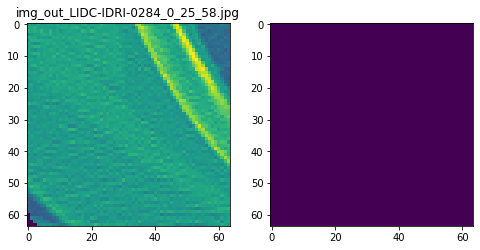

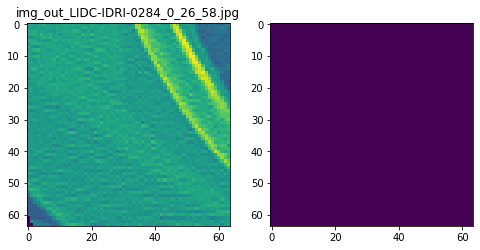

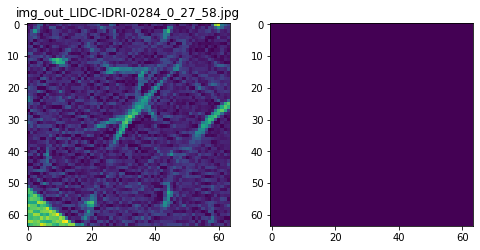

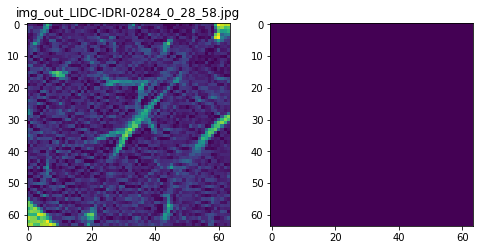

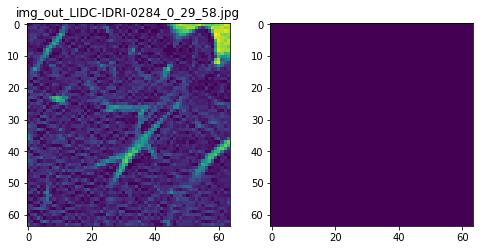

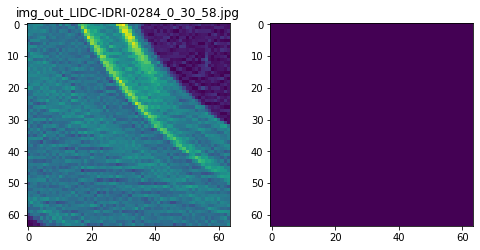

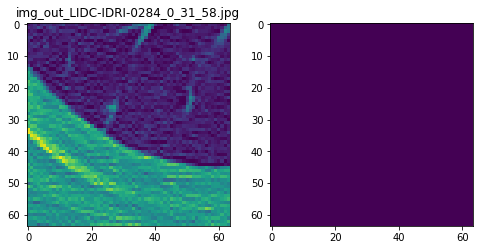

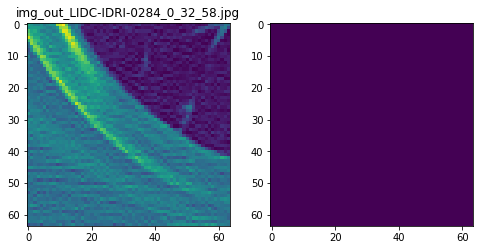

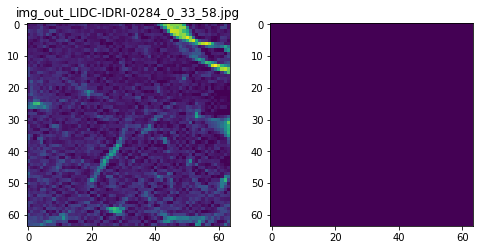

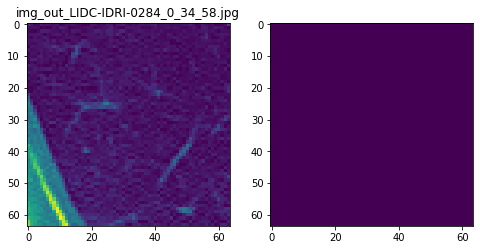

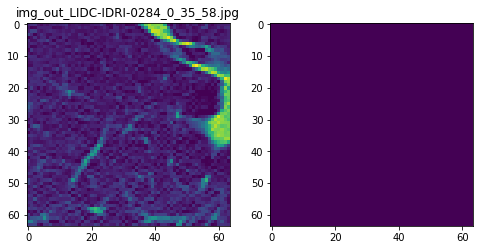

In [497]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0284')
print("There are {} nodules".format(len(cbbox)))
save_surrounding_images(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True)

In [294]:
# def validate_surrounding_images(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True):
#     devnull = open(os.devnull, 'w')
#     if image_save:
#         assert os.path.exists(root_dir)
#         image_dir = root_dir + '/images/'
#         mask_dir = root_dir + '/masks/'
#         assert os.path.exists(image_dir)
#         assert os.path.exists(mask_dir)
#     slcz = bounding_box[nodule_number][2]
#     unique_slice_ids = np.arange(slcz.start, slcz.stop)
#     voxel = CT_mask[:,:,bounding_box[nodule_number][2]]
#     img_voxel = vol[:,:,bounding_box[nodule_number][2]]
#     out_masks = []
#     out_images = []
#     out_slices = None
#     #print("voxel shape 2 = {}".format(voxel.shape[2]))
#     for slice_id in range(voxel.shape[2]):
#         boxes = get_bounding_box(voxel[:,:,slice_id])
#         if boxes is None:
#             print("No bounding box for {} and slice {}".format(patient_id, slice_id))
#             continue
#         slices = get_slices(boxes, False)
#         coords = get_all_box_centers(slices, 34)
#         out_slices = get_random_slices(coords, 3) # get 3 random 64x64 images randomly from the image that does not show the mask (i.e., negative samples)
#         out_slices = [out_slice + (bounding_box[nodule_number][2],) for out_slice in out_slices]
#         #out_slices = [(slice(y-32, y+32, None), slice(x-32, x+32, None), bounding_box[nodule_number][2]) for x,y in coords]
#         for out_slice in out_slices:
#             out_masks.append(voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
#             out_images.append(img_voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
# #             out_masks.append(CT_mask[out_slice])
# #             out_images.append(vol[out_slice])
    
#     errors = []
#     cnt = 0
#     #print("Unique slices = {}".format(len(unique_slice_ids)))
#     b=[]
#     for a1 in unique_slice_ids:
#         b.extend(np.repeat(a1, 3))
#     for idx, (slice1, mask )in enumerate(zip(b, out_masks)):
#         print("{}_{}_{}_{}".format(slice1,patient_id, nodule_number, idx))
#         if len(np.unique(mask)) > 1:
#             s = (np.sum(mask), idx, patient_id, nodule_number, unique_slice_id)
#             errors.append(s)
#         cnt += 1
#     return errors, cnt

In [21]:
"""
    Save the nodule image and at least one more random image with the nodule visible but not identical to the nodule image
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
"""
def save_image_foreach_slice(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    #get the clip such that the nodule is at the center of the 64x64 image
    slc = get_nodule_part(bounding_box[nodule_number], random, shape=(32, 32))

    assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
    for slice_index, unique_slice_id in zip(range(slc[2].stop - slc[2].start),unique_slice_ids):
        img = vol[slc[0],slc[1],slc[2]][:,:,slice_index]
        mask = CT_mask[slc[0],slc[1],slc[2]][:,:,slice_index]
        if img.shape != (64, 64):
            continue
        if mask.shape != (64, 64):
            continue
        if image_save:
            if random:
                image_file_name = "img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            else:
                image_file_name = "img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(image_dir + image_file_name, img)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(mask_dir + mask_file_name, mask)
        if image_plot:
            f, a =  plt.subplots(1,2, figsize=(8,10))
            a[0].imshow(img)
            if random:
                a[0].set_title("img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            else:
                a[0].set_title("img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            a[1].imshow(mask)
            plt.show()

In [22]:
# vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0284')
# print("There are {} nodules".format(len(cbbox)))
# save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
#                          vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=True)

In [23]:
# vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0001')
# print("There are {} nodules".format(len(cbbox)))
# save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0001', bounding_box=cbbox, nodule_number=0,  
#                          vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True)

#### Random crop images around nodules

In [24]:
"""
    Save the nodule image and at least one more random image with the nodule visible 
    but not identical to the nodule image
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    num_random_images = number of random crop images to generate around the nodule
"""
def save_random_crop_image_foreach_slice(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                                         image_save=False, image_plot=True, num_random_images=10):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    #slc = get_nodule_part(bounding_box[nodule_number], random)
    slc = get_nodule_part(bounding_box[nodule_number], random=False, shape=(64,64))
    
            
    assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
    for slice_index, unique_slice_id in zip(range(slc[2].stop - slc[2].start),unique_slice_ids):
        img = vol[slc[0],slc[1],slc[2]][:,:,slice_index]
        mask = CT_mask[slc[0],slc[1],slc[2]][:,:,slice_index]
        if img.shape != (128, 128):
            continue
        if mask.shape != (128, 128):
            continue
        #return an array of 10 (num_random_images) images
        X, Y = random_cropXY(img, mask, 32, num_random_images)
        
        if image_save:
            for rnd_img_id in range(len(X)):
                image_file_name = "img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                mask_file_name = "mask_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, X[rnd_img_id])
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(mask_dir + mask_file_name, Y[rnd_img_id])
        if image_plot:
            f, a =  plt.subplots(len(X),2, figsize=(len(X)*5,len(X)*5))
            for rnd_img_id in range(len(X)):
                a[rnd_img_id][0].imshow(X[rnd_img_id])
                a[rnd_img_id][0].set_title("img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id))
                a[rnd_img_id][1].imshow(Y[rnd_img_id])
            plt.show()

In [25]:
"""
    Get some random 64x64 images from the entire 512x512 image
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    num_random_images = number of random crop images to generate around the nodule
"""
def save_random_crop_image(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                                         image_save=False, image_plot=True, num_random_images=10):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    #slc = get_nodule_part(bounding_box[nodule_number], random)
    #slc = get_nodule_part(bounding_box[nodule_number], random=False, shape=(64,64))
    
            
    #assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
    for unique_slice_id in unique_slice_ids:
        img = vol[:,:,unique_slice_id]
        mask = CT_mask[:,:,unique_slice_id]
        if img.shape != (512, 512):
            continue
        if mask.shape != (512, 512):
            continue
        #return an array of 10 (num_random_images) images
        X, Y = random_cropXY(img, mask, 128+64+32, num_random_images)
        
        if image_save:
            for rnd_img_id in range(len(X)):
#                 if np.sum(Y[rnd_img_id]) > 0:
#                     continue
                image_file_name = "img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                mask_file_name = "mask_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, X[rnd_img_id])
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(mask_dir + mask_file_name, Y[rnd_img_id])
        if image_plot:
            f, a =  plt.subplots(len(X),2, figsize=(len(X)*5,len(X)*5))
            for rnd_img_id in range(len(X)):
#                 if np.sum(Y[rnd_img_id]) > 0:
#                     continue
                a[rnd_img_id][0].imshow(X[rnd_img_id])
                a[rnd_img_id][0].set_title("img_random_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id, rnd_img_id))
                a[rnd_img_id][1].imshow(Y[rnd_img_id])
            plt.show()

Loading dicom files ... This may take a moment.


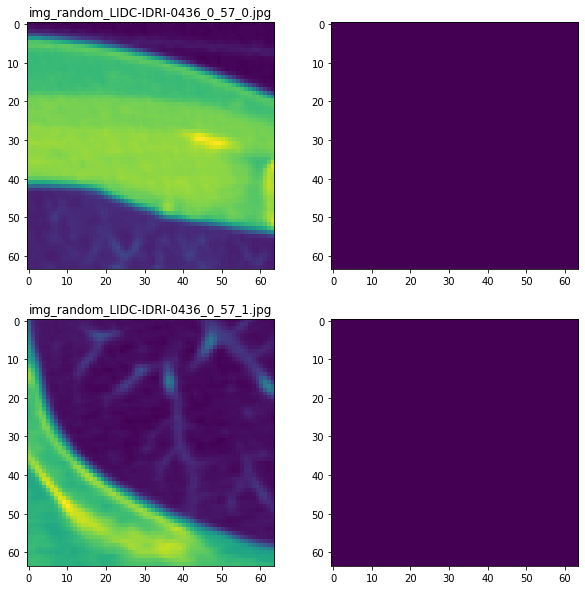

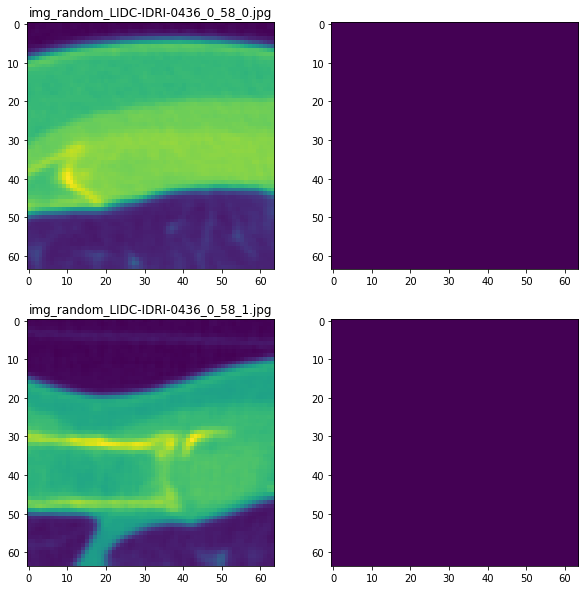

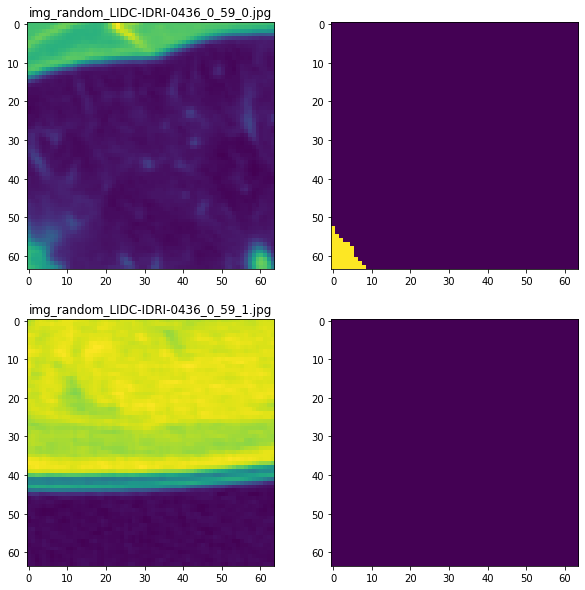

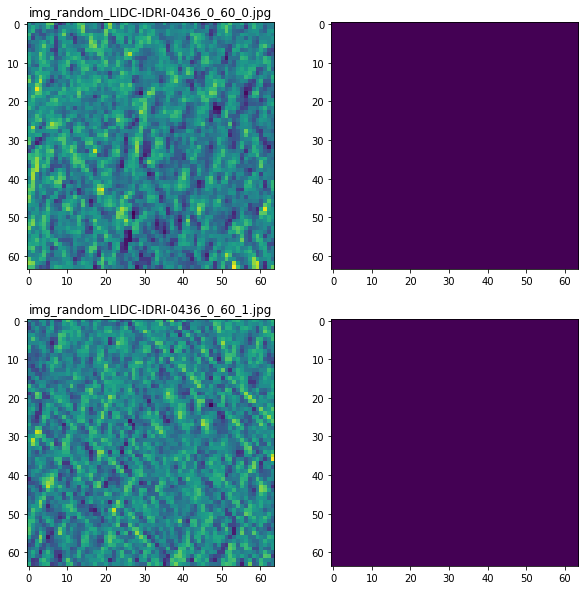

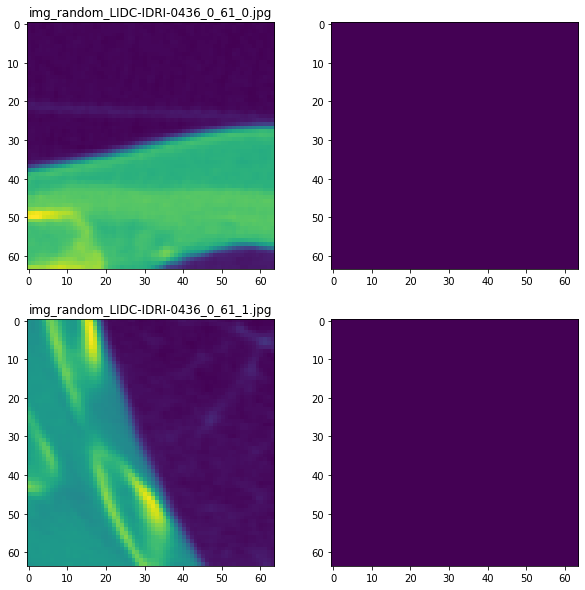

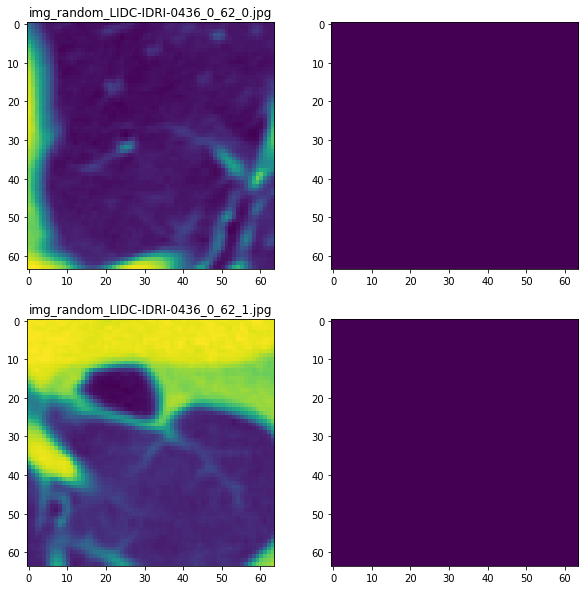

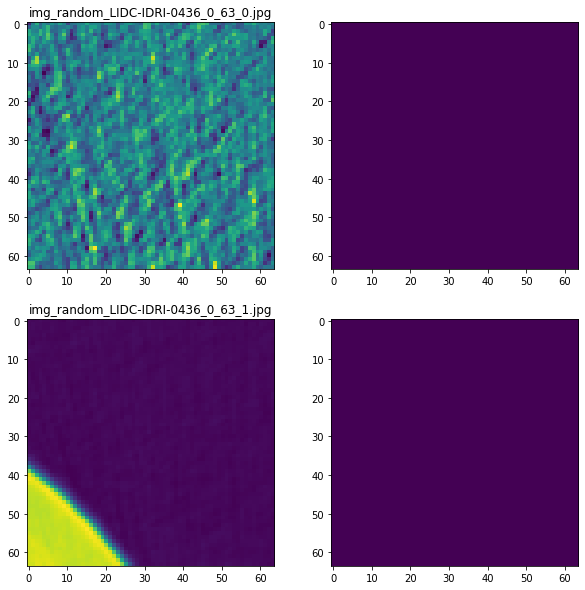

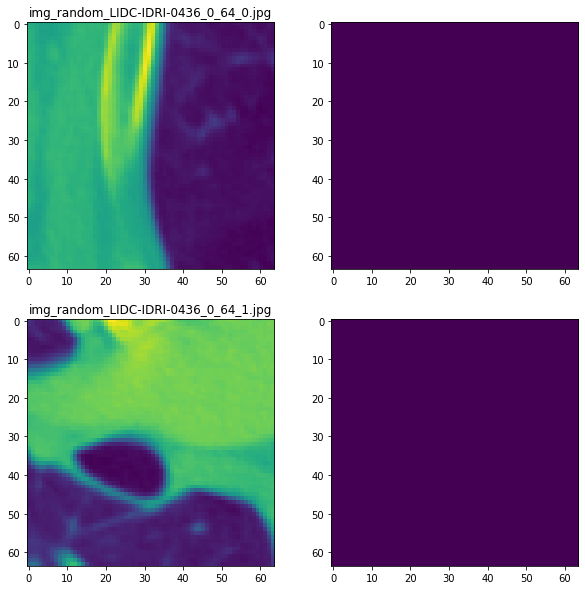

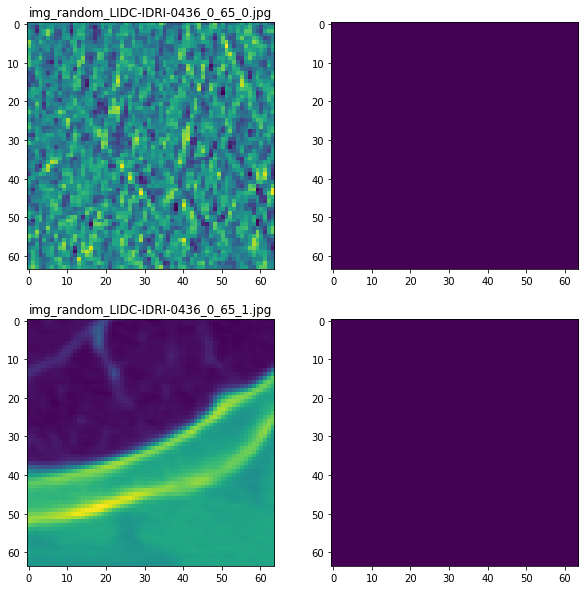

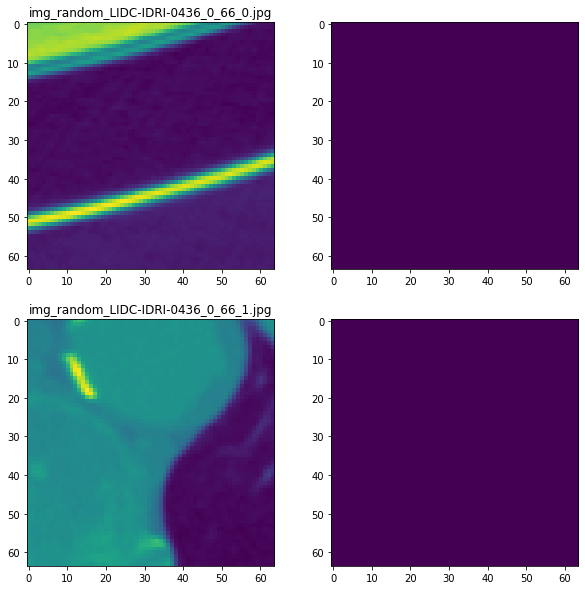

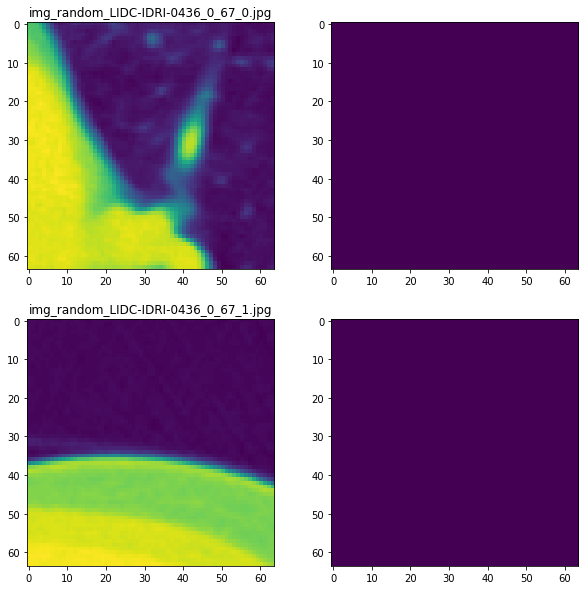

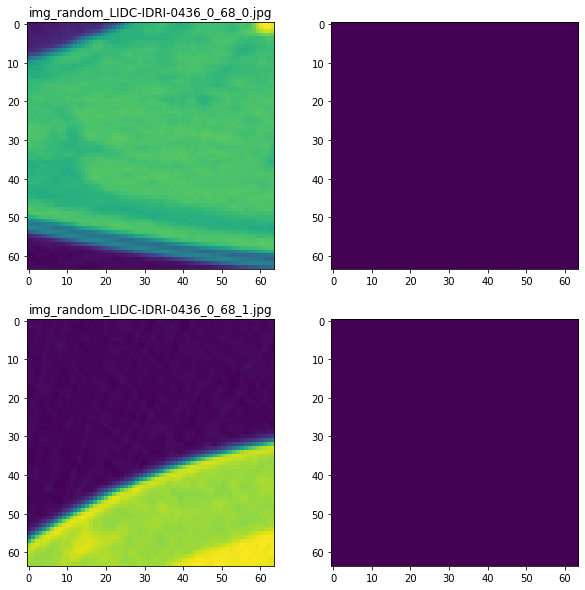

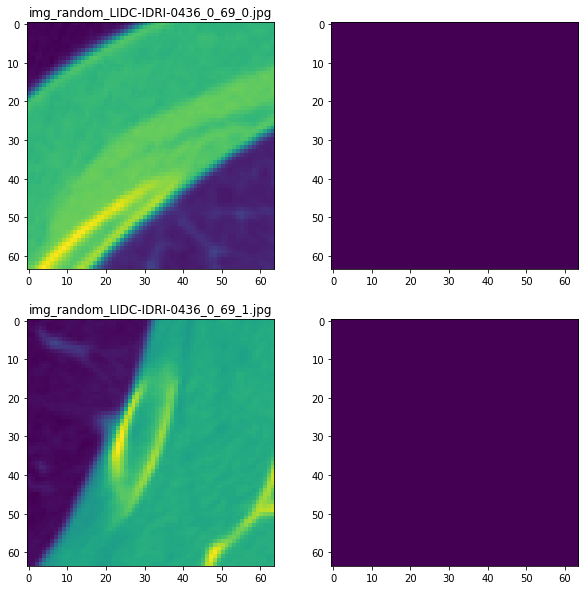

In [565]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir='/data/yolov5/test/sorted_gcsfiles', patient_id='LIDC-IDRI-0436')
save_random_crop_image(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, num_random_images=2)

Loading dicom files ... This may take a moment.
(64, 64)
(64, 64)


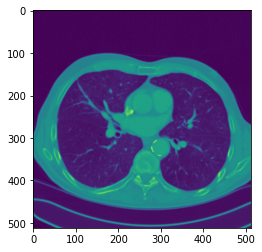

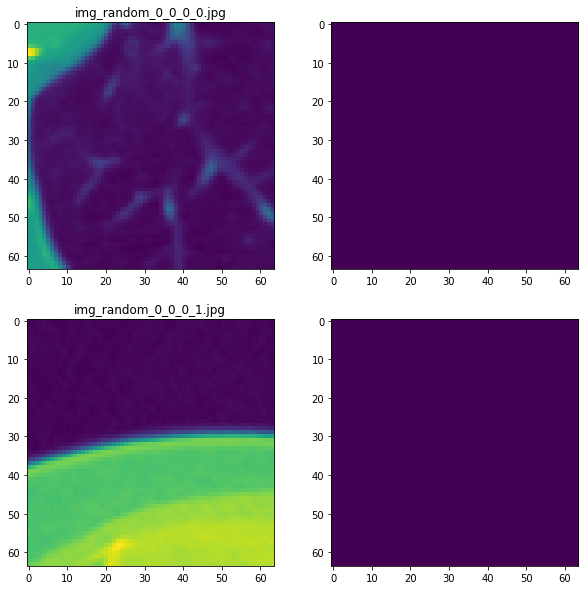

In [552]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir='/data/yolov5/test/sorted_gcsfiles', patient_id='LIDC-IDRI-0436')
plt.imshow(vol[:,:,cbbox[0][2]][:,:,0])
img = vol[:,:,cbbox[0][2]][:,:,0]
mask = CT_mask[:,:,cbbox[0][2]][:,:,0]

X, Y = random_cropXY(img, mask, 128+64+32, 2)

f, a =  plt.subplots(len(X),2, figsize=(len(X)*5,len(X)*5))
for rnd_img_id in range(len(X)):
    print(X[rnd_img_id].shape)
    a[rnd_img_id][0].imshow(X[rnd_img_id])
    a[rnd_img_id][0].set_title("img_random_{}_{}_{}_{}.jpg".format(0, 0, 0, rnd_img_id))
    a[rnd_img_id][1].imshow(Y[rnd_img_id])
plt.show()

#### Test the image generation code

Loading dicom files ... This may take a moment.


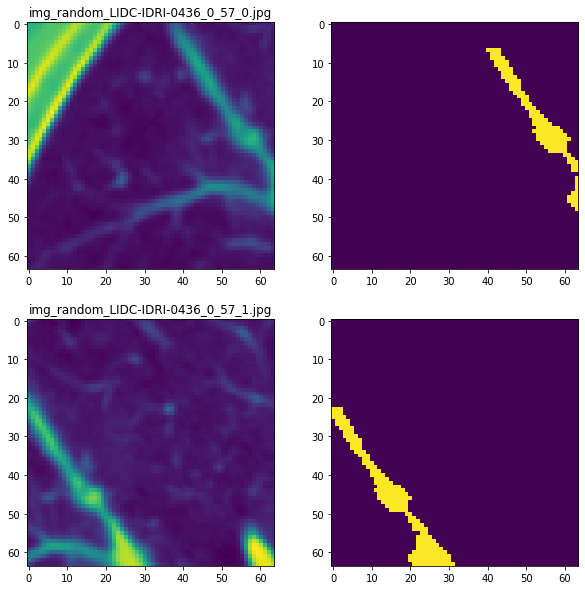

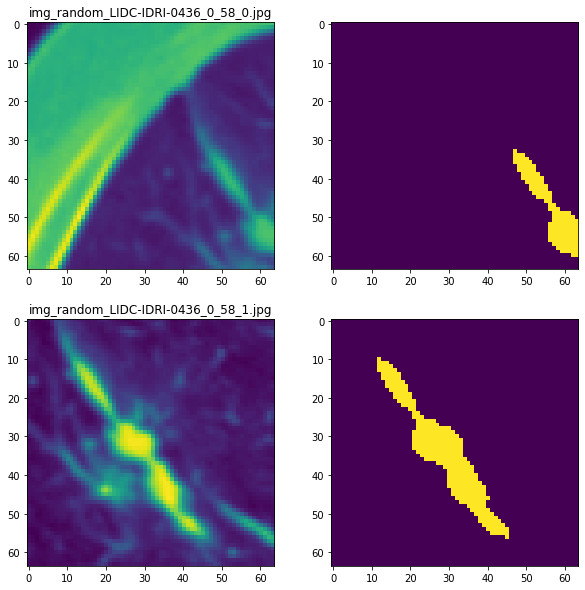

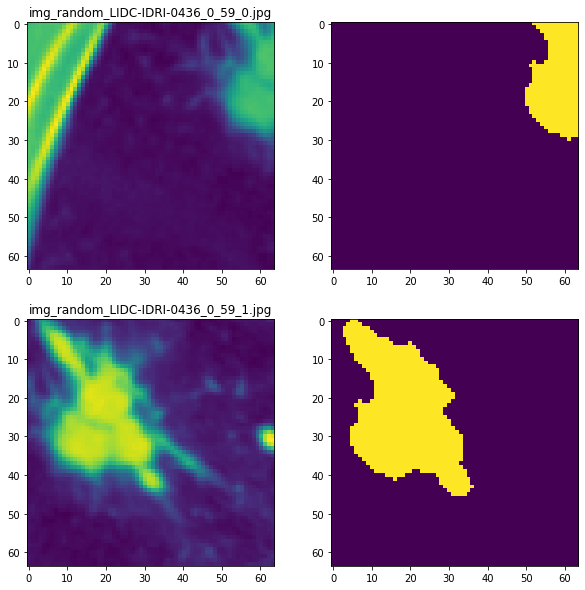

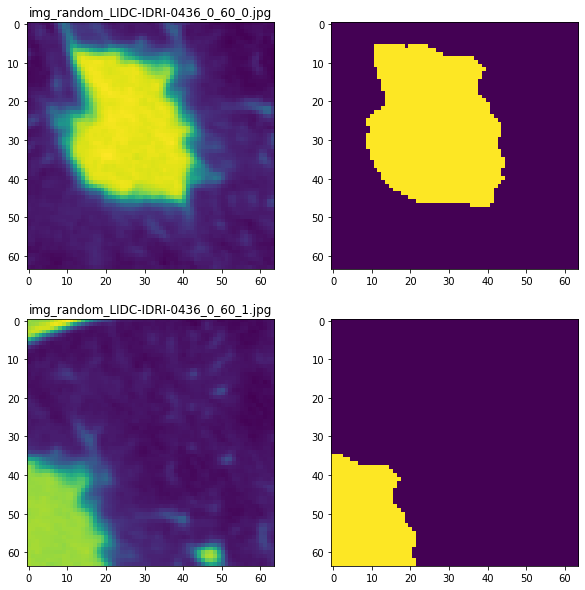

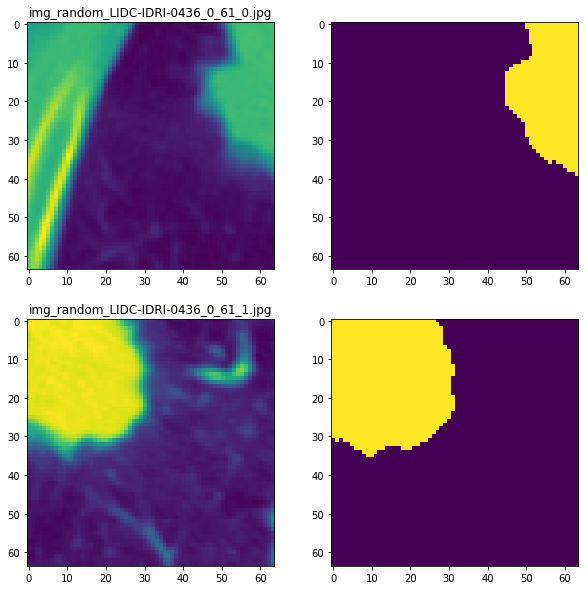

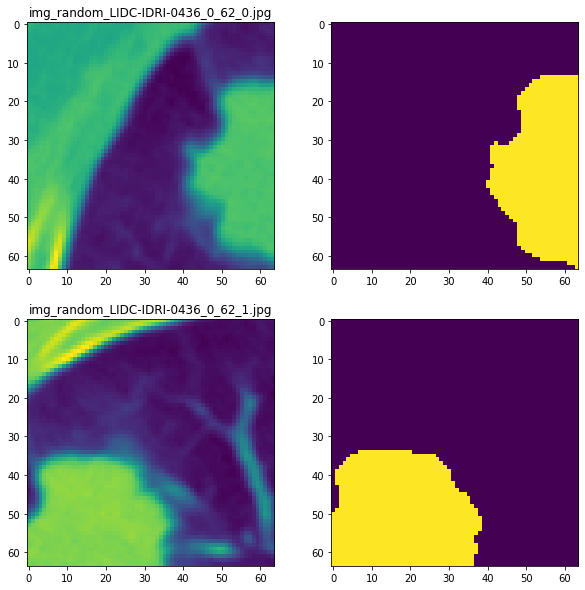

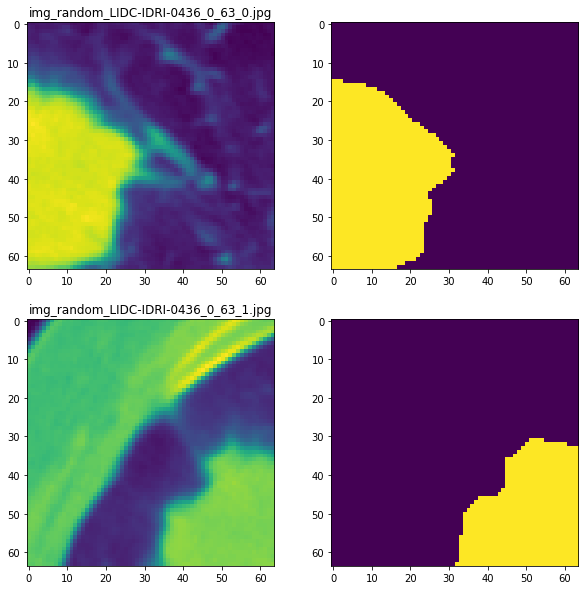

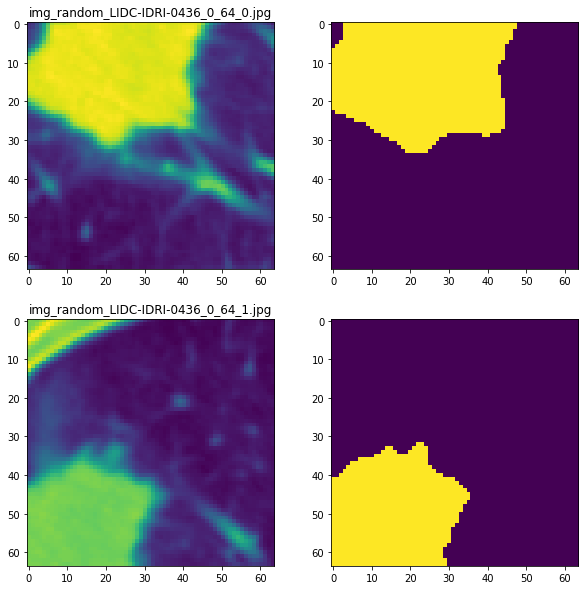

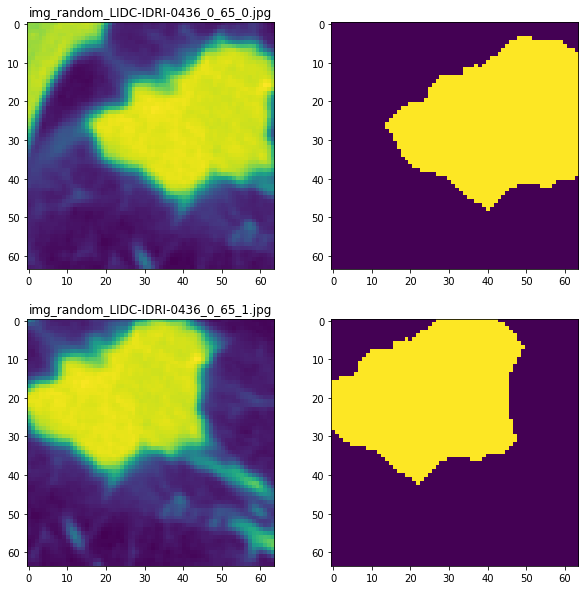

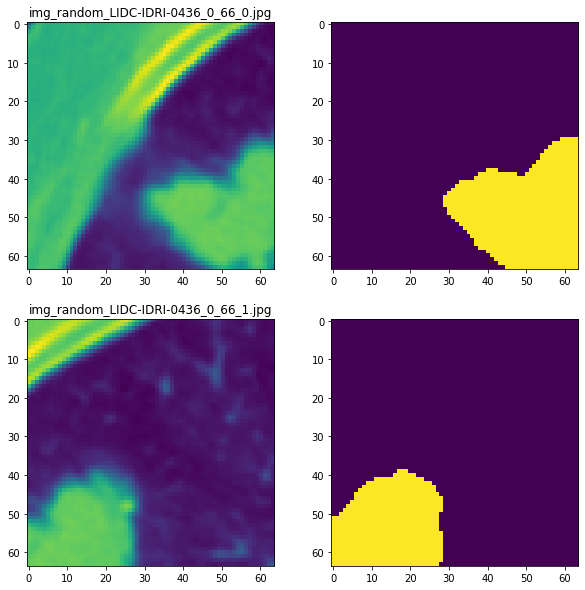

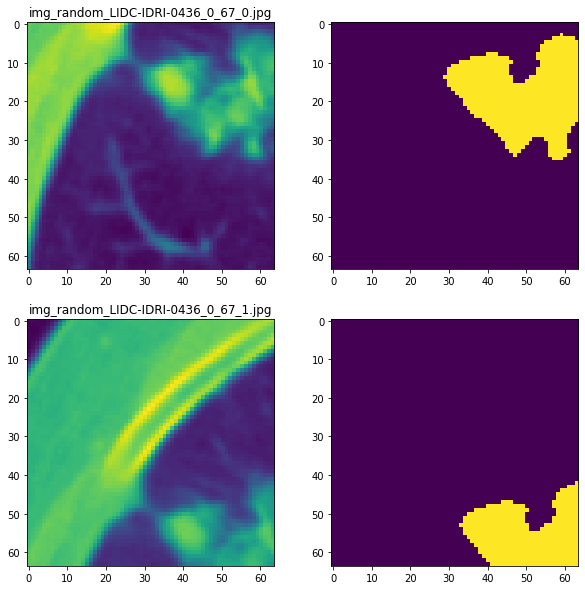

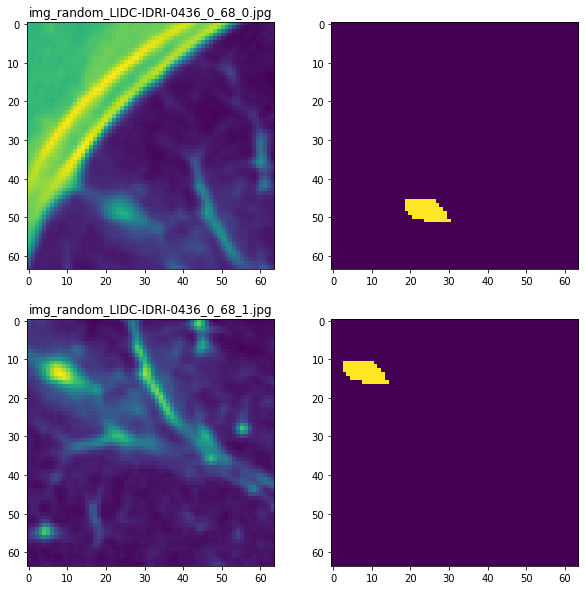

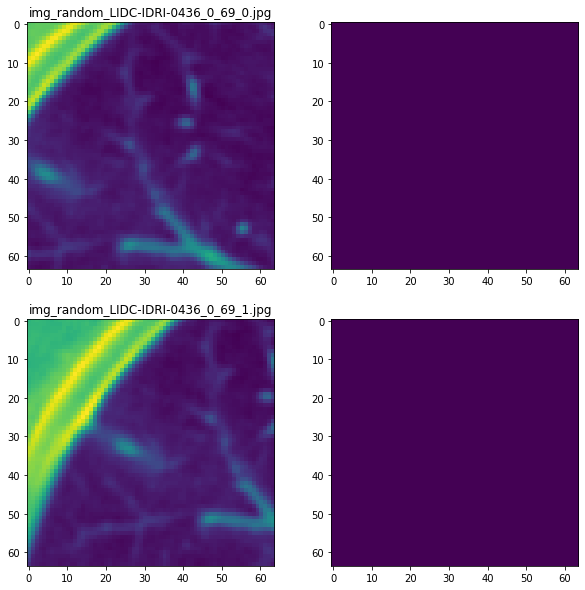

In [499]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir='/data/yolov5/test/sorted_gcsfiles', patient_id='LIDC-IDRI-0436')
save_random_crop_image_foreach_slice(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, num_random_images=2)

Loading dicom files ... This may take a moment.


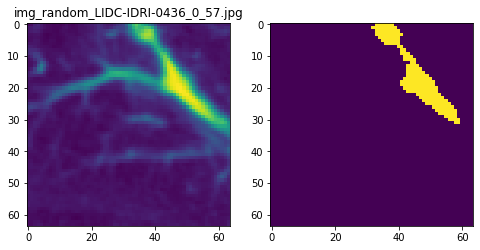

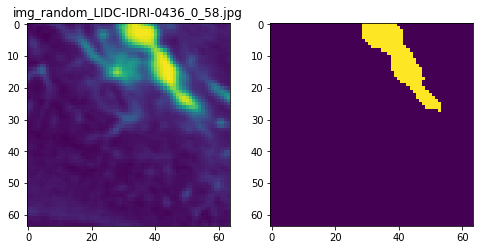

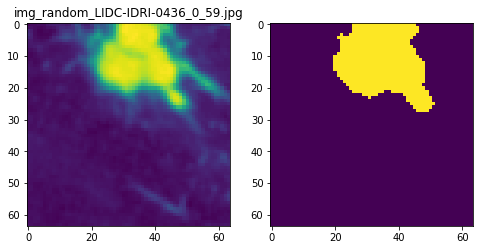

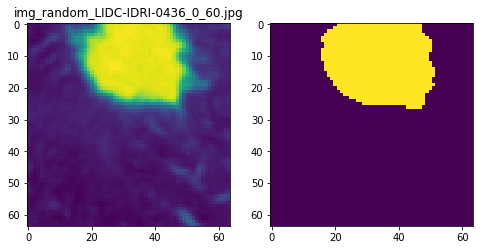

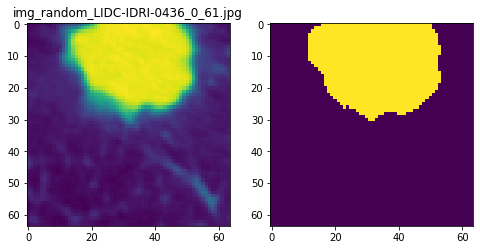

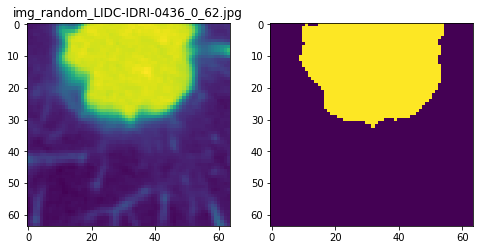

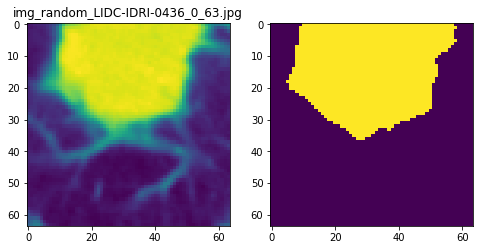

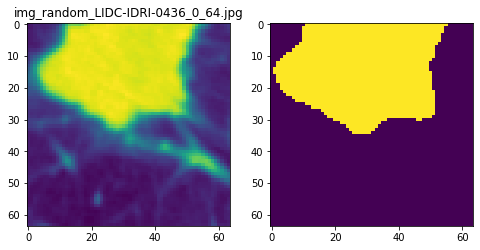

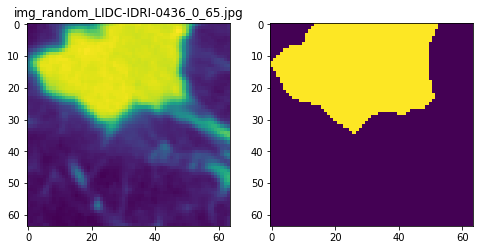

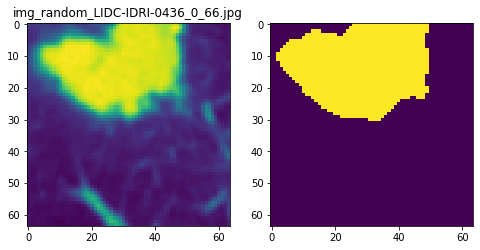

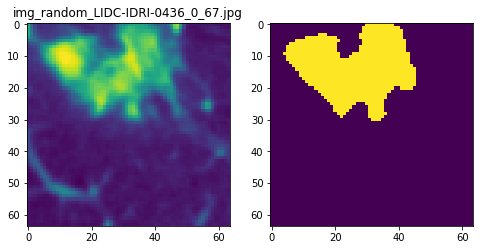

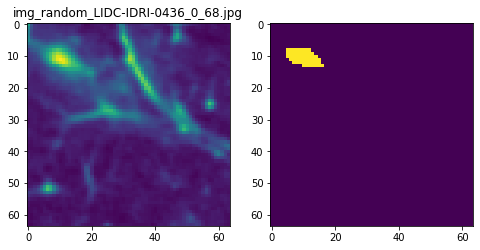

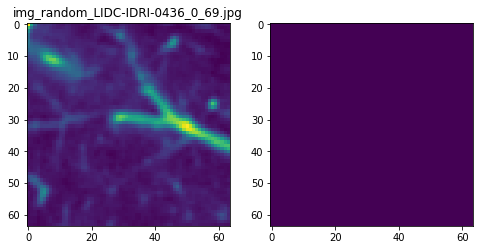

In [501]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')
save_image_foreach_slice(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True)

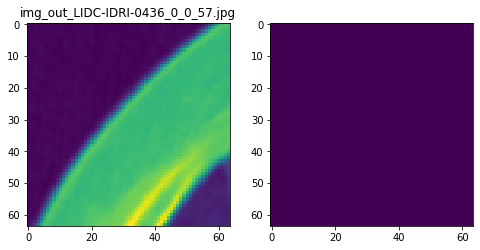

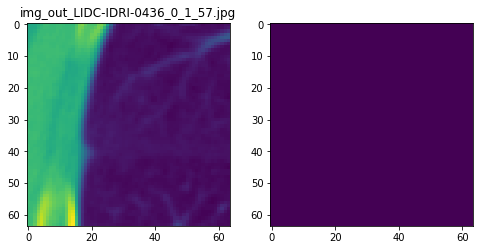

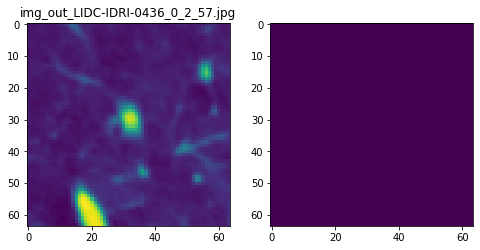

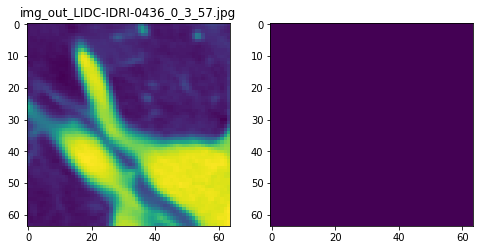

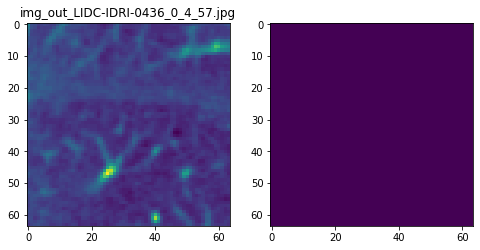

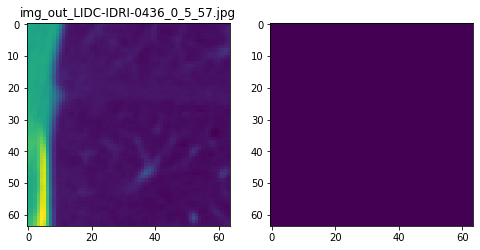

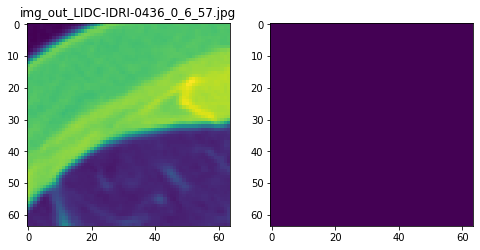

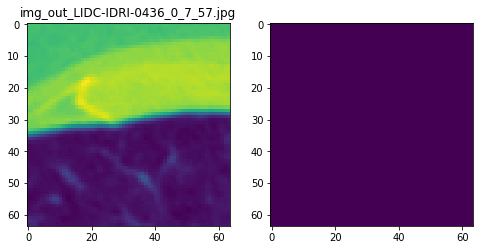

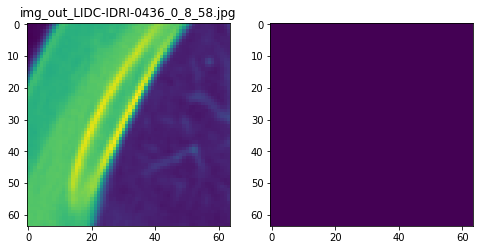

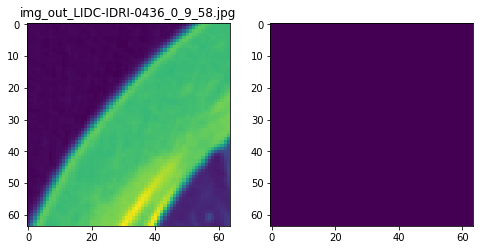

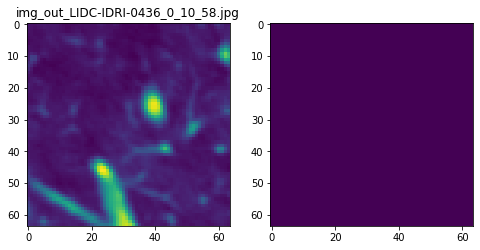

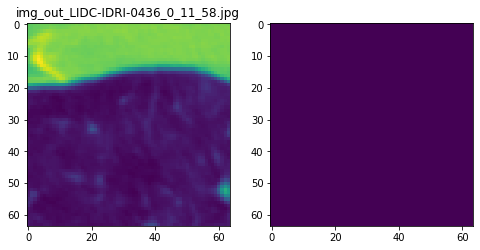

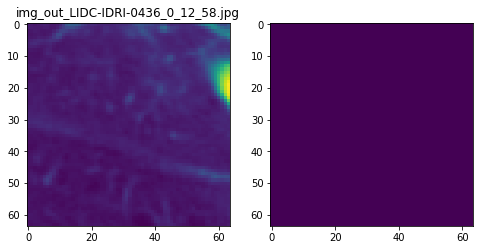

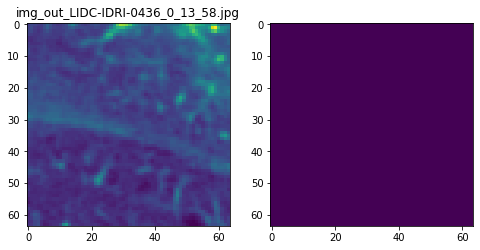

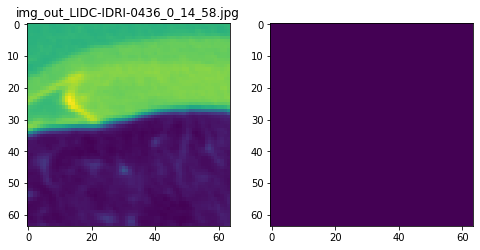

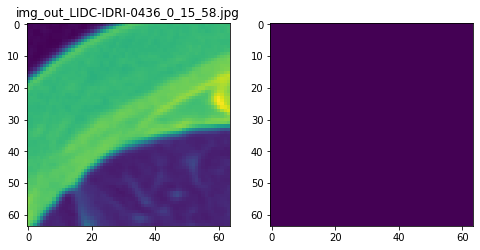

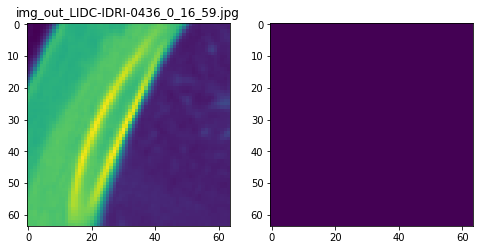

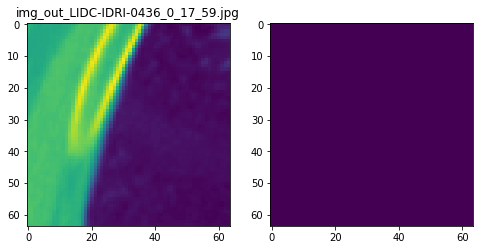

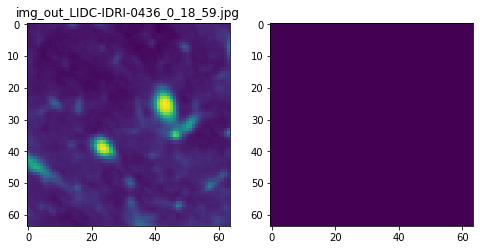

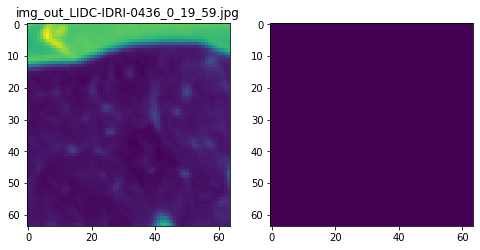

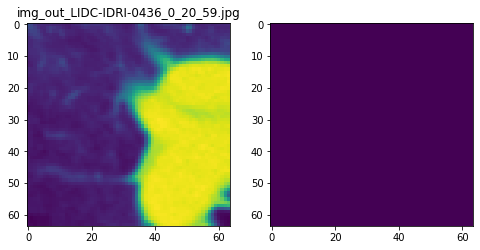

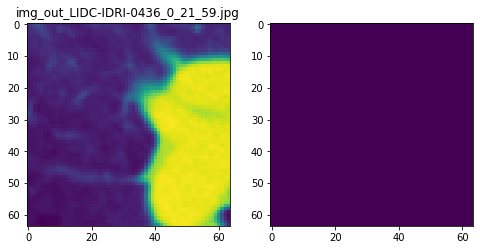

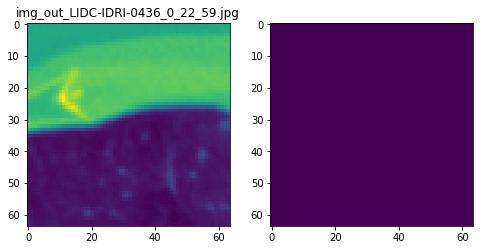

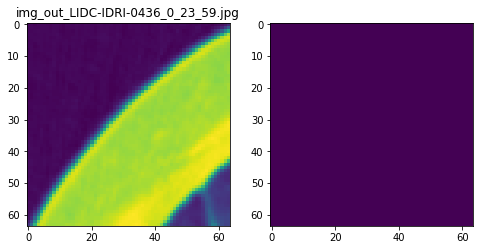

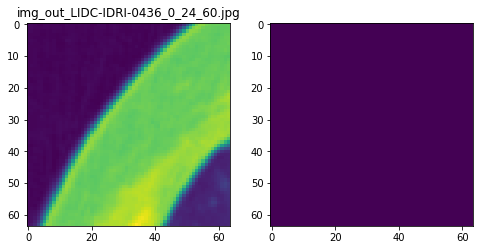

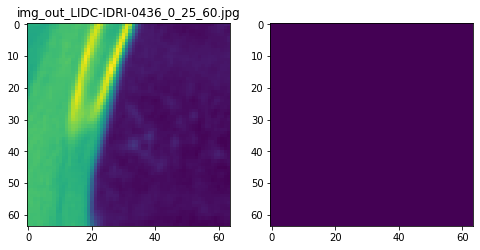

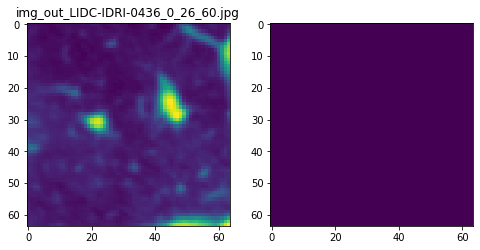

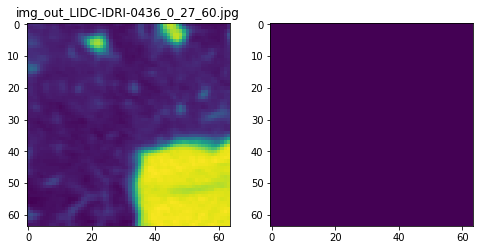

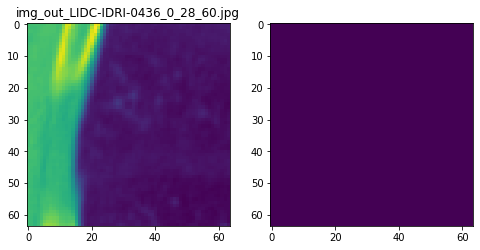

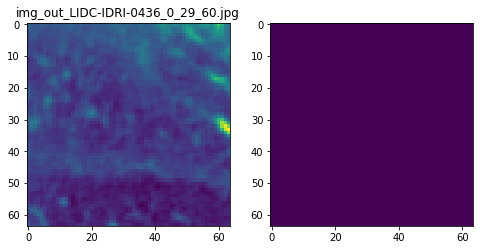

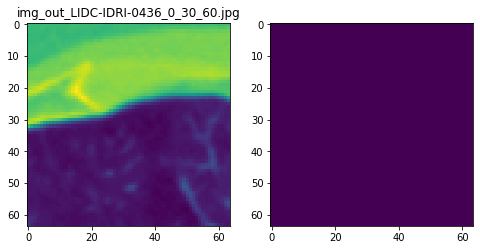

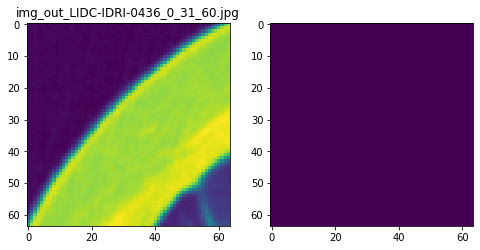

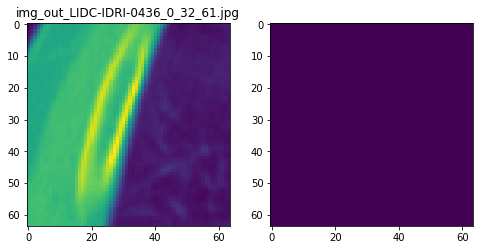

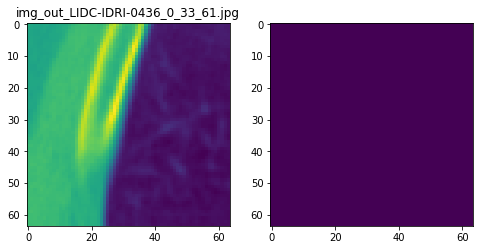

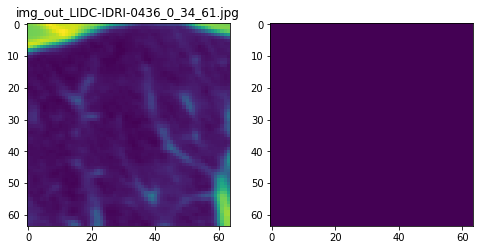

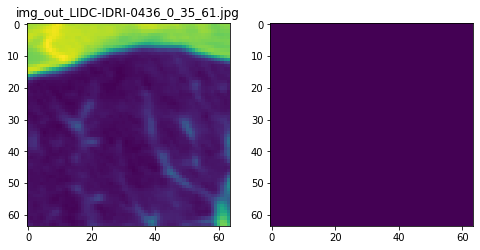

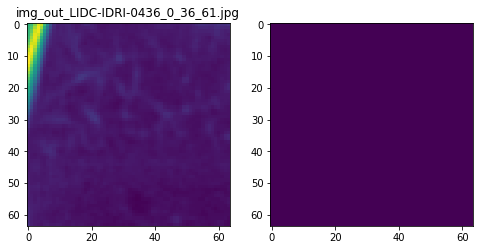

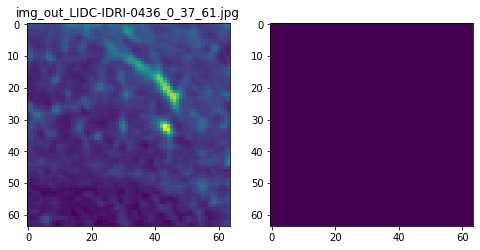

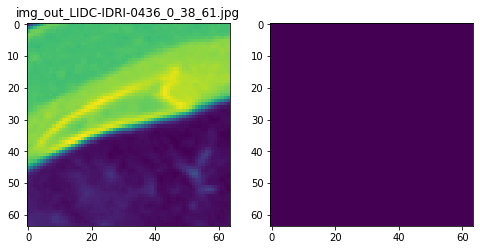

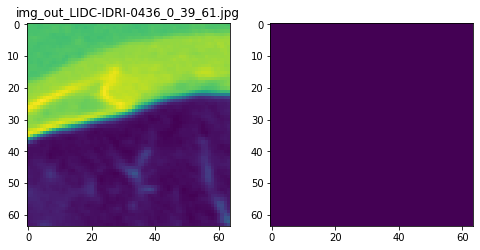

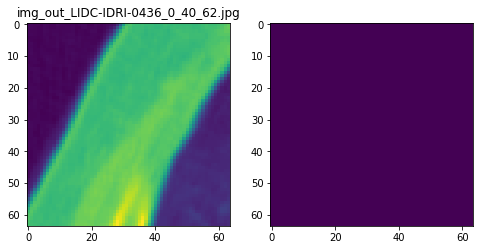

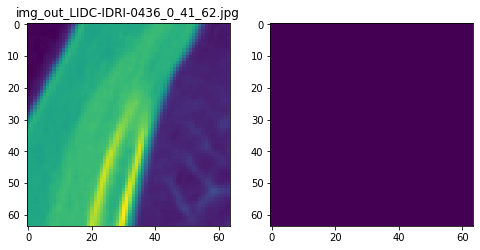

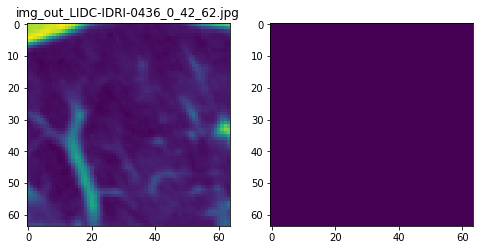

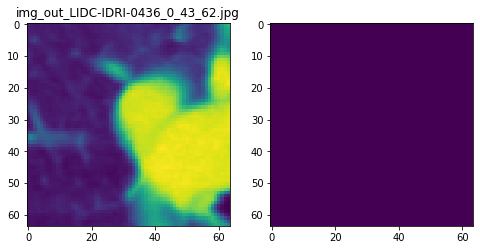

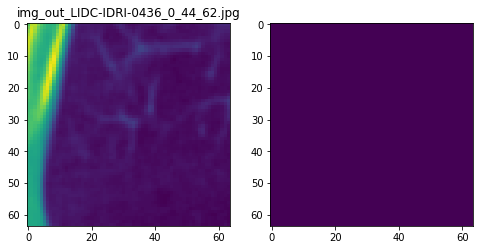

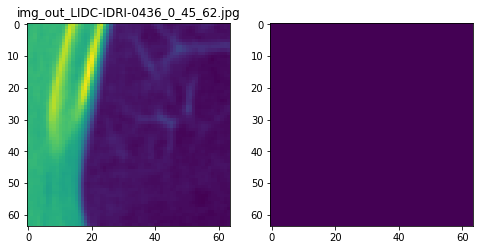

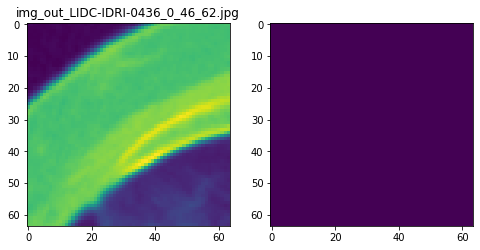

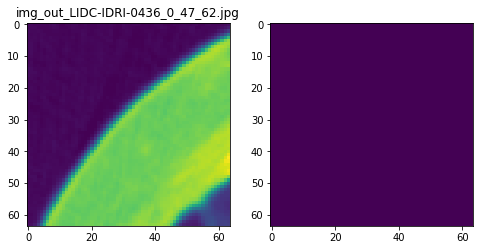

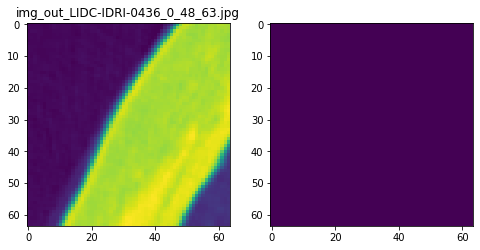

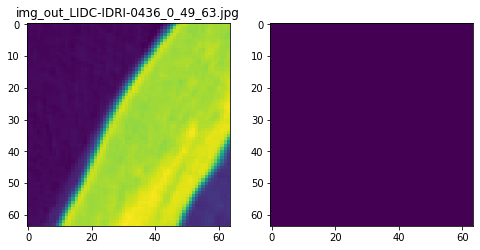

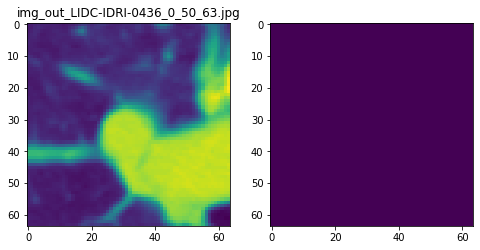

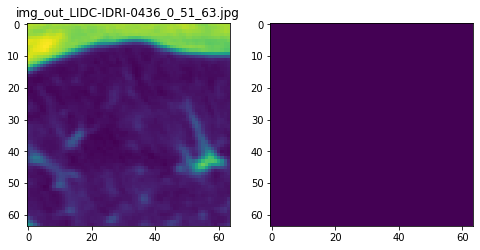

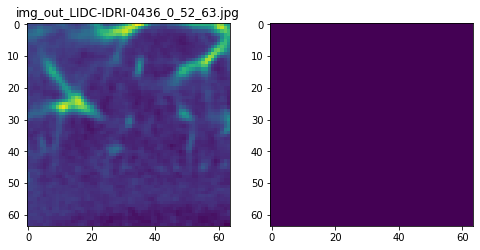

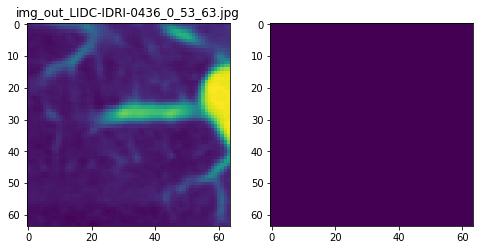

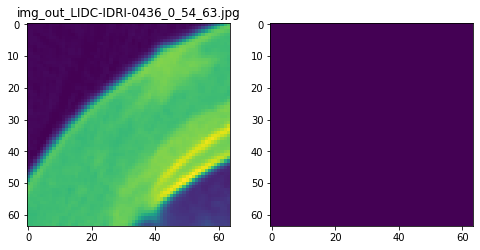

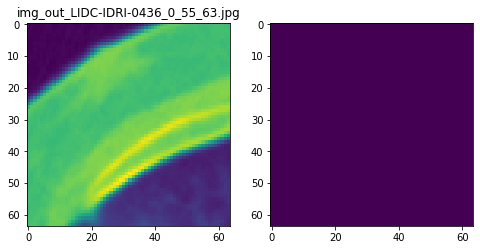

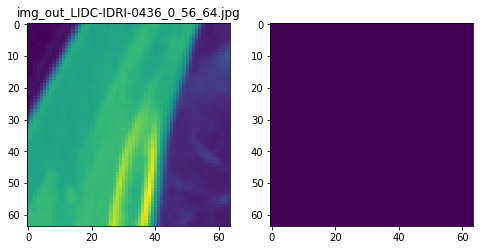

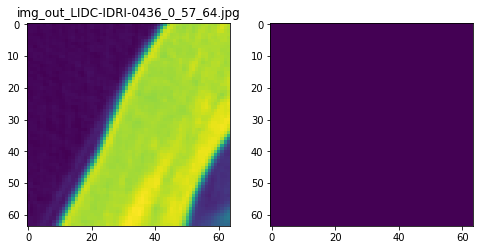

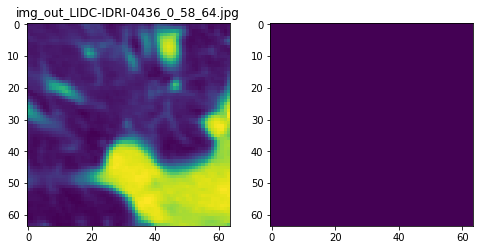

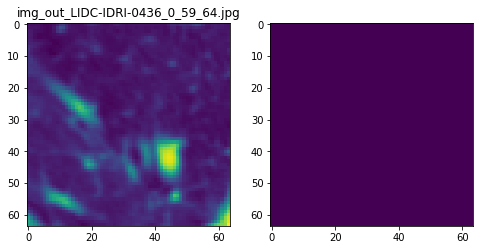

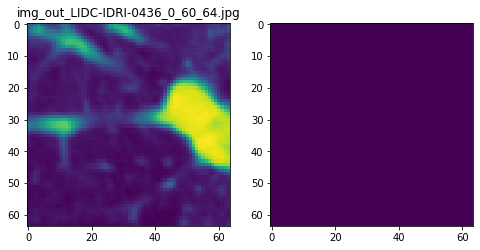

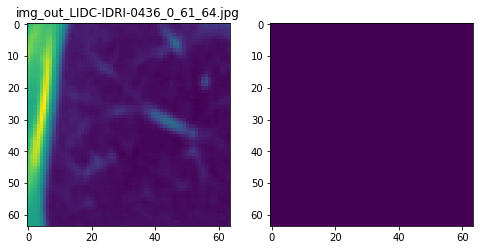

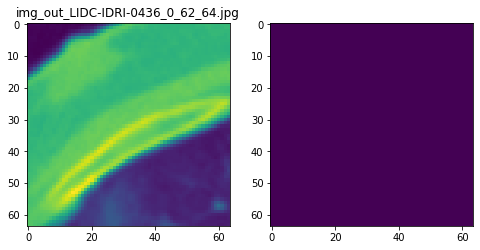

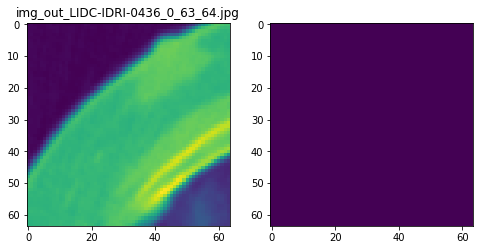

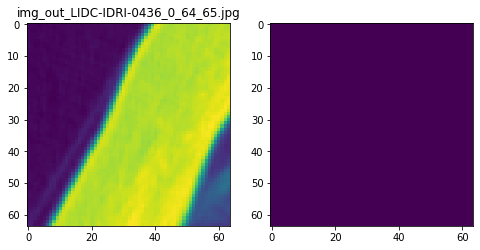

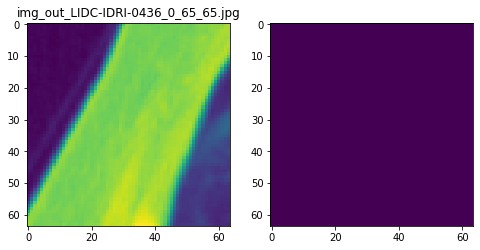

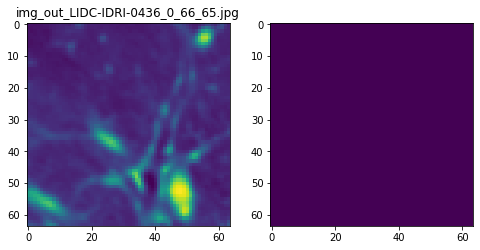

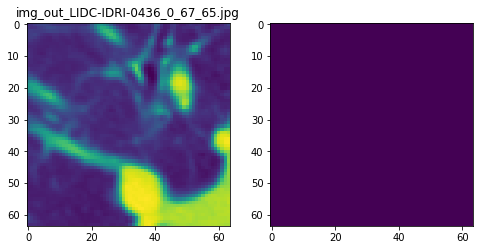

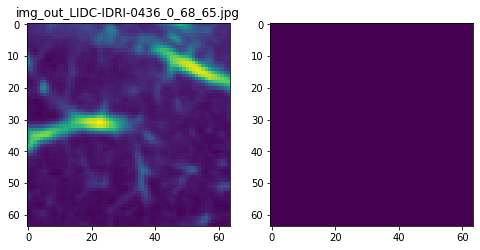

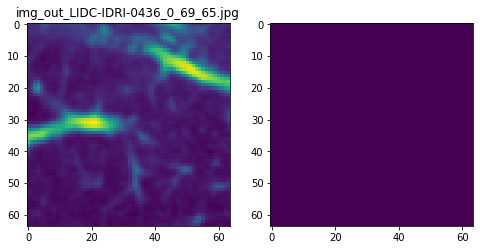

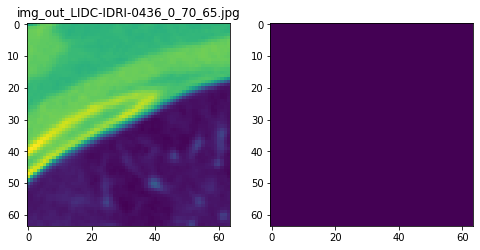

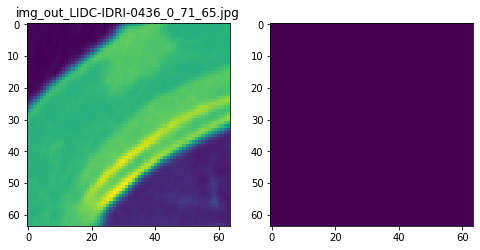

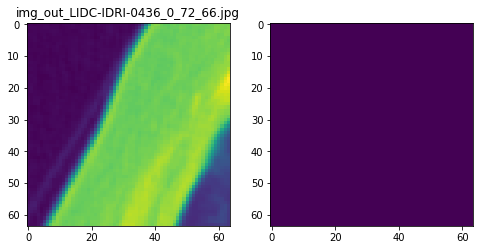

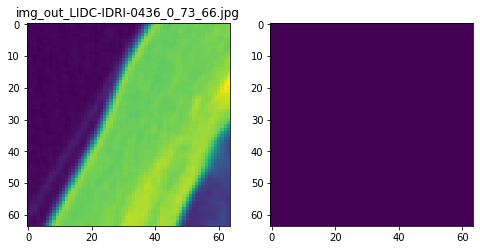

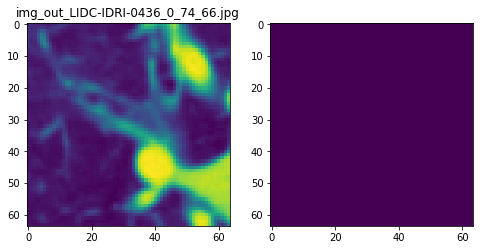

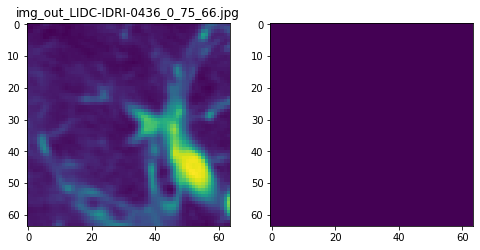

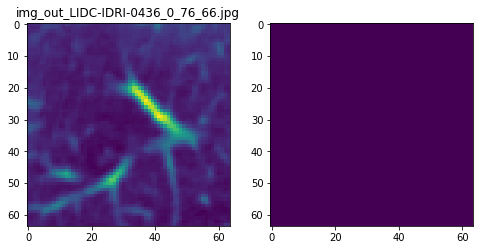

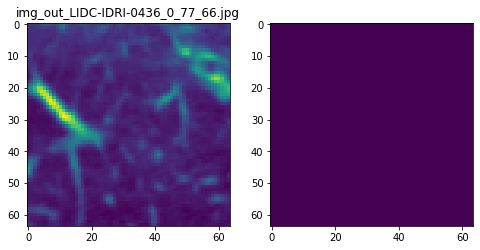

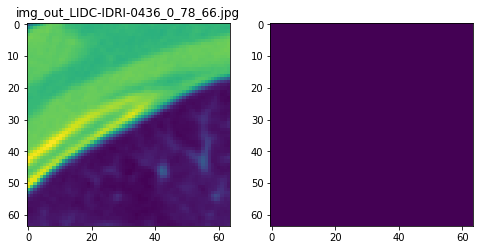

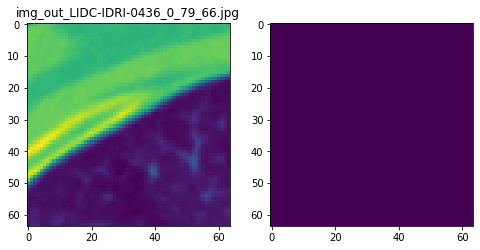

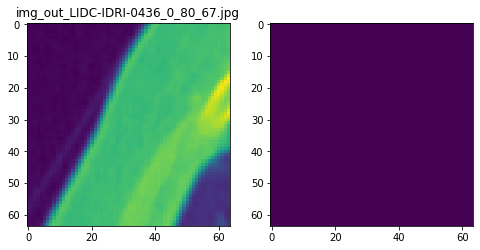

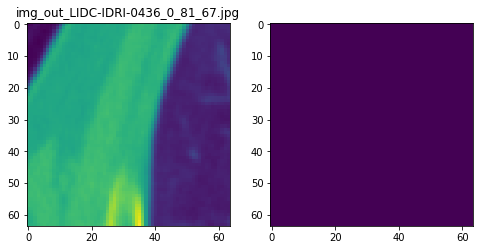

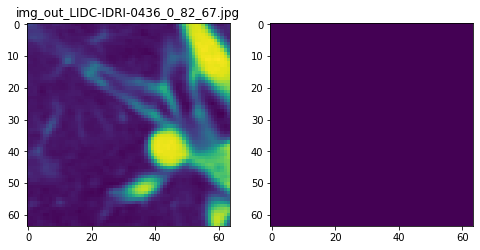

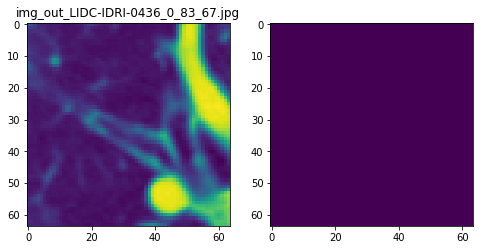

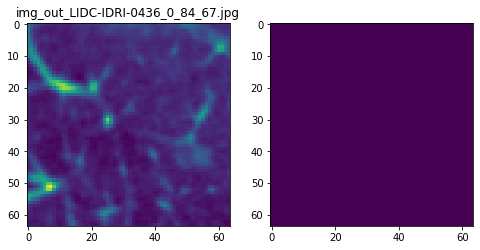

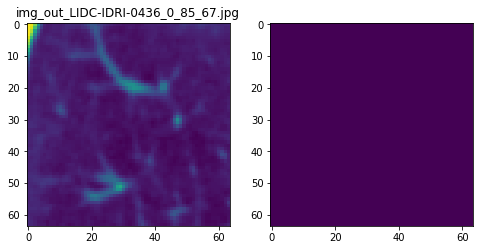

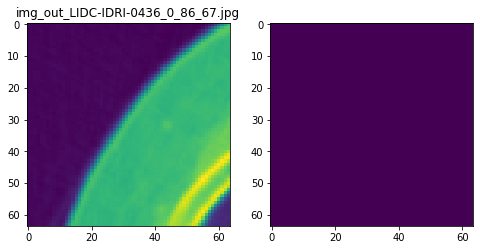

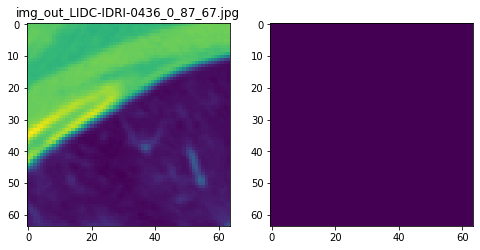

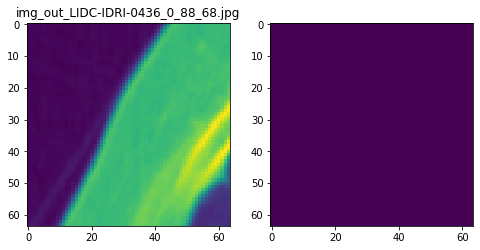

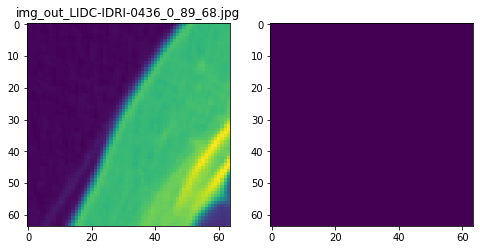

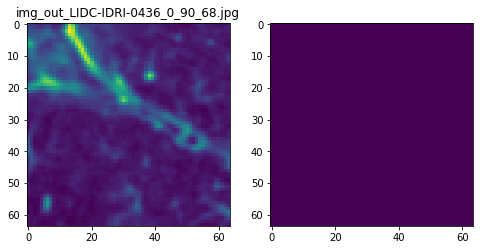

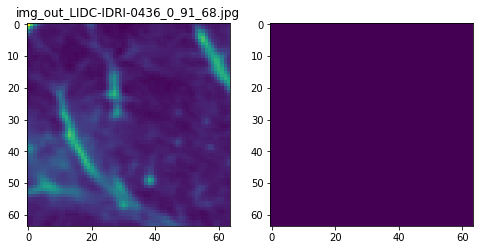

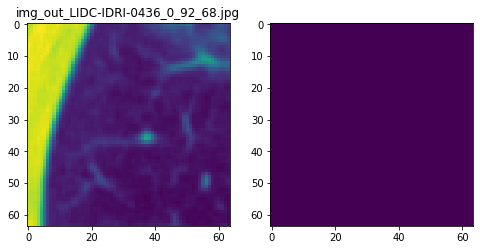

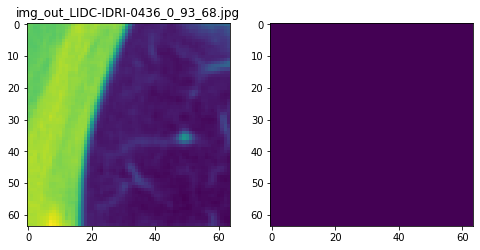

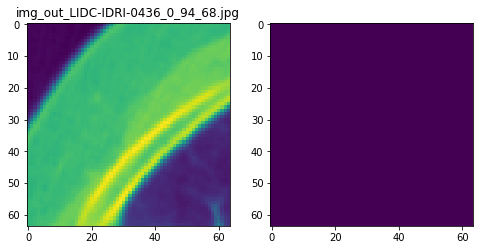

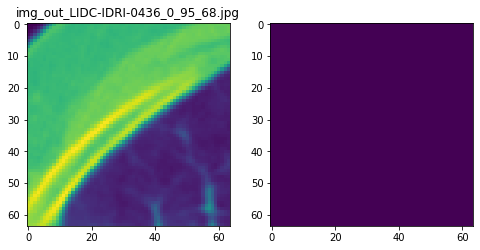

In [102]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')
save_surrounding_images(root_dir='/data/unet/test/', patient_id='LIDC-IDRI-0436', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=False, image_plot=True, num_random_images=8)

#### Generate and save images for each patients  

In [26]:
def save_generated_images_for_patient(root_dir='/data/unet/train/', dicom_dir='/rawdata/train/sorted_gcsfiles', patient_id='LIDC-IDRI-0284'):
    vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir, patient_id)
    if cbbox:
        for nodule_num in range(len(cbbox)):
            #this gives 2 images per slice, generate num_random_images positive images
            save_random_crop_image_foreach_slice(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=False, num_random_images=12)
            #this gives one image per slice
            save_image_foreach_slice(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=False, image_save=True, image_plot=False)
            #this gives 2 image per slice along each side of the nodule bounding box, use num_images in multiples of 4 since there are 4 sides
            #generate num_random_images negative images
            save_surrounding_images(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=False, num_random_images=12)

In [27]:
import os
root_path = '/data/unet/train/'
"""
    UNET data dir should have only images and masks folder and should be empty
"""
def check_dirs(root_path):
    dirs = os.listdir(root_path)
    s = np.setdiff1d(np.array(['images', 'masks']), np.array(dirs))
    assert len(s) == 0, "Directory structure not correct!"
    for d in dirs:
        tmp = root_path + "/" + d
        if os.path.exists(tmp):
            files = os.listdir(tmp)
            assert len(files) <= 0, "Directory not empty!"

In [28]:
%%time
patients = os.listdir('/rawdata/train/sorted_gcsfiles')
root_dir = '/data/unet/train/'
check_dirs(root_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=root_dir, dicom_dir='/rawdata/train/sorted_gcsfiles', patient_id=pat)

  4%|███████▉                                                                                                                                                                                              | 28/696 [01:25<38:11,  3.43s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 17%|█████████████████████████████████                                                                                                                                                                    | 117/696 [05:52<41:47,  4.33s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 18%|██████████████████████████████████▊                                                                                                                                                                  | 123/696 [06:14<33:33,  3.51s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 23%|█████████████████████████████████████████████▌                                                                                                                                                       | 161/696 [08:14<28:18,  3.17s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 257/696 [12:51<39:00,  5.33s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 45%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 311/696 [15:29<22:52,  3.56s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 452/696 [22:09<08:54,  2.19s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 453/696 [22:11<08:39,  2.14s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 567/696 [27:43<04:31,  2.11s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 584/696 [28:39<06:50,  3.66s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 696/696 [33:45<00:00,  2.91s/it]

CPU times: user 22min 12s, sys: 5min 29s, total: 27min 41s
Wall time: 33min 45s


In [29]:
%%time
patients = os.listdir('/rawdata/yolov5/val/sorted_gcsfiles')
root_dir = '/data/unet/val/'
check_dirs(root_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=root_dir, dicom_dir='/rawdata/yolov5/val/sorted_gcsfiles/', patient_id=pat)

 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 62/155 [02:27<04:20,  2.81s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 85/155 [03:14<03:09,  2.71s/it]

Error loading DICOM for patient LIDC-IDRI-0355


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [05:51<00:00,  2.27s/it]

CPU times: user 4min 13s, sys: 1min 3s, total: 5min 17s
Wall time: 5min 51s


In [30]:
%%time
patients = os.listdir('/data/yolov5/test/sorted_gcsfiles')
root_dir = '/data/unet/test/'
check_dirs(root_dir)
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir=root_dir, dicom_dir='/data/yolov5/test/sorted_gcsfiles/', patient_id=pat)

 19%|█████████████████████████████████████▌                                                                                                                                                                  | 9/48 [00:26<01:54,  2.93s/it]

Error loading DICOM for patient LIDC-IDRI-0484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:00<00:00,  2.51s/it]

CPU times: user 1min 27s, sys: 22.2 s, total: 1min 49s
Wall time: 2min


In [89]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP

#### UNET model training

##### Collect the training and validation images and masks

In [85]:
train_image_files = os.listdir('/data/unet/train/images/')
train_mask_files = [im_file.replace('img', 'mask') for im_file in train_image_files]

val_image_files = os.listdir('/data/unet/val/images/')
val_mask_files = [im_file.replace('img', 'mask') for im_file in val_image_files]


test_image_files = os.listdir('/data/unet/test/images/')
test_mask_files = [im_file.replace('img', 'mask') for im_file in test_image_files]

In [33]:
[(a,b) for a,b in zip(train_image_files[:5], train_mask_files[:5])][:5]

[('img_out_LIDC-IDRI-0601_2_72_95.jpg', 'mask_out_LIDC-IDRI-0601_2_72_95.jpg'),
 ('img_out_LIDC-IDRI-0094_0_82_298.jpg',
  'mask_out_LIDC-IDRI-0094_0_82_298.jpg'),
 ('img_out_LIDC-IDRI-0196_0_39_100.jpg',
  'mask_out_LIDC-IDRI-0196_0_39_100.jpg'),
 ('img_out_LIDC-IDRI-0705_0_116_97.jpg',
  'mask_out_LIDC-IDRI-0705_0_116_97.jpg'),
 ('img_random_LIDC-IDRI-0242_0_107_8.jpg',
  'mask_random_LIDC-IDRI-0242_0_107_8.jpg')]

### Examine the data

In [79]:
#tr_mask_files = os.listdir(train_mask_files)
mask_visible_cnt = 0
for fl in train_mask_files:
    img = Image.open('/data/unet/train/masks/' + fl)
    if len(np.unique(np.array(img))) > 1:
        mask_visible_cnt += 1

In [81]:
print(mask_visible_cnt/len(train_mask_files))

0.3959200757826096


In [82]:
#tr_mask_files = os.listdir(train_mask_files)
val_mask_visible_cnt = 0
for fl in val_mask_files:
    img = Image.open('/data/unet/val/masks/' + fl)
    if len(np.unique(np.array(img))) > 1:
        val_mask_visible_cnt += 1

In [83]:
print(val_mask_visible_cnt/len(val_mask_files))

0.3834607561198008


In [86]:
test_mask_visible_cnt = 0
for fl in test_mask_files:
    img = Image.open('/data/unet/test/masks/' + fl)
    if len(np.unique(np.array(img))) > 1:
        test_mask_visible_cnt += 1

In [87]:
print(test_mask_visible_cnt/len(test_mask_files))

0.43513170869136497


(64, 64, 3)


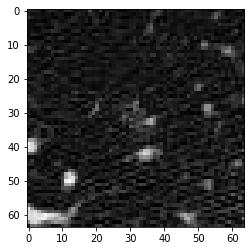

In [192]:
arr = Image.open('/data/unet/train/images/img_LIDC-IDRI-0686_2_182.jpg').convert('RGB')

print(np.array(arr).shape)
plt.imshow(np.array(arr))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


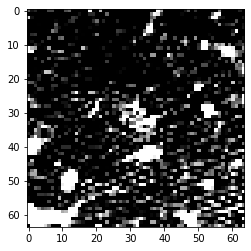

In [198]:
im = np.array(arr)
im = im.astype(np.uint8).astype('float32')
im -= np.mean(im)
im /= np.std(im)
#im = im.astype(np.uint8)
plt.imshow(im)
print(im.shape)

##### Dataloader for the pytorch model training

In [212]:
from PIL import Image
class nodule_data(Dataset):
    def __init__(self,root_dir, image_paths,mask_paths):
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        try:
            image = Image.open(self.root_dir + 'images/' + self.image_paths[index])
            mask = Image.open(self.root_dir + 'masks/' + self.mask_paths[index])
            mask = mask.convert('1')
            mask = np.array(mask)
            mask = mask.astype(np.uint8)
            image -= np.mean(image)
            image /= np.std(image)
        except:
            #issues loading image, return blank image and mask
            print("Found an issue with image {}".format(self.image_paths[index]))
            image = np.zeros([512, 512])
            mask = np.zeros([512, 512])
            mask = mask.astype(np.uint8)
            image -= np.mean(image)
            image /= np.std(image)
        return image[np.newaxis,:].astype('float32'), mask[np.newaxis,:].astype('float32')#, self.image_paths[index], self.mask_paths[index]
            

batch_size = 32
num_workers = 4

nodule_data_train = nodule_data('/data/unet/train/',train_image_files, train_mask_files)
train_loader = DataLoader(nodule_data_train, batch_size = batch_size,
                             num_workers = num_workers)

nodule_data_val = nodule_data('/data/unet/val/',val_image_files, val_mask_files)
val_loader = DataLoader(nodule_data_val, batch_size = batch_size,
                             num_workers = num_workers)

In [211]:
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


In [203]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


#### Define the model

In [213]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
#            enc_ftrs = self.crop(encoder_features[i], x)
#            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
#    def crop(self, enc_ftrs, x):
#        _, _, H, W = x.shape
#        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#        return enc_ftrs

class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [60]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 1


In [61]:
model = Unet()
model = torch.nn.parallel.DataParallel(model, device_ids=[0]).cuda()

In [62]:
device = torch.device("cuda")

In [63]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
             Block-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,928
             ReLU-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [64]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    #print('label shape=', y_true.ndim)
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [65]:
# DICE when using images with nodules as well as blank images
def dice_coeff_2(y_true, y_pred):
    smooth = 0.0001
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
    return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

#### Configure metrics logging in tensorboard

In [66]:
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter('runs/unet_lidc_2')

In [67]:
def get_next_rundir():
    dirs = os.listdir('runs')
    idx = np.sort([int(d.split('_')[2]) for d in dirs])[-1]
    newdirname = 'runs/unet_lidc_{}'.format(idx+1)
    return newdirname

In [283]:
get_next_rundir()

'runs/unet_lidc_3'

In [92]:
def train(train_epochs):
    
    num_epochs = train_epochs
    
    
    criterion  = nn.BCEWithLogitsLoss()
    #optimizer  = torch.optim.Adam(model.parameters(),0.0001)
    #TODO: fix this later
    learning_rate = 0.001
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    rundir = get_next_rundir()
    writer = SummaryWriter(rundir)
    
    train_loss = []
    val_loss   = []
    best_dice = 0
    best_loss = 1
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        running_loss = 0.0
        batch_dice_score = []
        epoch_dice_score = []
        start = time.time()
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss = loss.item()
            running_loss += curr_loss
            epoch_loss += curr_loss

            # begin: DICE score
            #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
            mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            batch_dice_score.append(score)
            epoch_dice_score.append(score)
            # end: DICE score

            if i % 100 == 99: # every 10 minibatch
                writer.add_scalar('training loss', running_loss/100, epoch * len(train_loader) + i)
                writer.add_scalar('training dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                running_loss = 0.0
                batch_dice_score = []

        epoch_loss /= i+1
        train_loss.append(epoch_loss)
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))

        end = time.time()
        print(f"Epoch {epoch} trained with loss: {epoch_loss}, and dice score {epoch_dice_score}. The running time is {end-start}.")

        model.eval()
        running_loss = 0.0
        epoch_loss = 0.0
        running_score = 0.0
        start = time.time()
        batch_dice_score = []
        epoch_dice_score = []
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                curr_loss = loss.item()
                running_loss += curr_loss
                epoch_loss += curr_loss

                # begin: DICE score
                #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
                mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
                outputs = np.squeeze(mask_pre_prob).detach().cpu()
                mask_pre = np.where(outputs>0.5, 1,0)
                mask_pre = torch.from_numpy(mask_pre)
                score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
                batch_dice_score.append(score)
                epoch_dice_score.append(score)
                # end: DICE score

                if i % 100 == 99: # every 10 minibatch
                    writer.add_scalar('eval loss', running_loss/100, epoch * len(val_loader) + i)
                    writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                    running_loss = 0.0
                    batch_dice_score = []
        
        
        epoch_loss /= i+1
        #running_score /= i+1
        val_loss.append(epoch_loss)
        end = time.time()
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))
        print(f"Epoch {epoch} evaluated with loss: {epoch_loss}, and dice score: {epoch_dice_score}. The running time is {end-start}.")
        #update scheduler step
        scheduler.step(epoch_dice_score)

        #if running_loss == min(val_loss):
        PATH = f'{rundir}/Epoch{epoch}.pth'
        torch.save(model.state_dict(),PATH)
        print('Last model saved at epoch:', epoch)
        if epoch_dice_score > best_dice:
            best_dice = epoch_dice_score
            PATH = f'{rundir}/best_{epoch}.pth'
            torch.save(model.state_dict(),PATH)
            print('Best model saved at epoch:', epoch)

    print("Training is completed.")

In [94]:
train(20)

Epoch 0 trained with loss: 0.008570861661546799, and dice score 0.7397491335868835. The running time is 131.18606185913086.
Epoch 0 evaluated with loss: 0.028010429371244403, and dice score: 0.5770056843757629. The running time is 7.291146278381348.
Last model saved at epoch: 0
Best model saved at epoch: 0
Epoch 1 trained with loss: 0.007742402181186837, and dice score 0.759922206401825. The running time is 132.38868689537048.
Epoch 1 evaluated with loss: 0.029966988377356608, and dice score: 0.5580467581748962. The running time is 7.324808835983276.
Last model saved at epoch: 1
Epoch 2 trained with loss: 0.007345647437411339, and dice score 0.7719350457191467. The running time is 132.42327117919922.
Epoch 2 evaluated with loss: 0.029909593548579767, and dice score: 0.5882118344306946. The running time is 7.301647424697876.
Last model saved at epoch: 2
Best model saved at epoch: 2
Epoch 3 trained with loss: 0.00711724923875536, and dice score 0.7809988856315613. The running time is 132

KeyboardInterrupt: 

In [146]:
#model = Unet()
brain_model = torch.nn.parallel.DataParallel(brain_model, device_ids=[0]).cuda()

In [147]:
device = torch.device("cuda")

In [216]:
from PIL import Image
class nodule_data(Dataset):
    def __init__(self,root_dir, image_paths,mask_paths):
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        try:
            image = Image.open(self.root_dir + 'images/' + self.image_paths[index]).convert('RGB')
            mask = Image.open(self.root_dir + 'masks/' + self.mask_paths[index])
            
#             image -= np.mean(image)
#             image /= np.std(image)
            
            image = Image.fromarray(np.array(image)).convert('RGB')
            image = np.array(image).astype('float32')
            image -= np.mean(image)
            image /= np.std(image)
            
            mask = mask.convert('1')
            mask = np.array(mask)
            mask = mask.astype(np.uint8)
        except:
            #issues loading image, return blank image and mask
            print("Found an issue with image {}".format(self.image_paths[index]))
            image = np.zeros([512, 512])
            mask = np.zeros([512, 512])
            mask = mask.astype(np.uint8)
            image = Image.fromarray(image).convert('RGB')
#             image -= np.mean(image)
#             image /= np.std(image)
        return image[np.newaxis,:,:,:].astype('float32'), mask[np.newaxis,:].astype('float32')#, self.image_paths[index], self.mask_paths[index]
            

batch_size = 32
num_workers = 4

nodule_data_train = nodule_data('/data/unet/train/',train_image_files, train_mask_files)
train_loader = DataLoader(nodule_data_train, batch_size = batch_size,
                             num_workers = num_workers)

nodule_data_val = nodule_data('/data/unet/val/',val_image_files, val_mask_files)
val_loader = DataLoader(nodule_data_val, batch_size = batch_size,
                             num_workers = num_workers)

In [215]:
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


In [145]:
def train_2(model, train_epochs):
    
    num_epochs = train_epochs
    
    
    criterion  = nn.BCEWithLogitsLoss()
    #optimizer  = torch.optim.Adam(model.parameters(),0.0001)
    #TODO: fix this later
    learning_rate = 0.001
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    rundir = get_next_rundir()
    writer = SummaryWriter(rundir)
    
    train_loss = []
    val_loss   = []
    best_dice = 0
    best_loss = 1
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        running_loss = 0.0
        batch_dice_score = []
        epoch_dice_score = []
        start = time.time()
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss = loss.item()
            running_loss += curr_loss
            epoch_loss += curr_loss

            # begin: DICE score
            #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
            mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            batch_dice_score.append(score)
            epoch_dice_score.append(score)
            # end: DICE score

            if i % 100 == 99: # every 10 minibatch
                writer.add_scalar('training loss', running_loss/100, epoch * len(train_loader) + i)
                writer.add_scalar('training dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                running_loss = 0.0
                batch_dice_score = []

        epoch_loss /= i+1
        train_loss.append(epoch_loss)
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))

        end = time.time()
        print(f"Epoch {epoch} trained with loss: {epoch_loss}, and dice score {epoch_dice_score}. The running time is {end-start}.")

        model.eval()
        running_loss = 0.0
        epoch_loss = 0.0
        running_score = 0.0
        start = time.time()
        batch_dice_score = []
        epoch_dice_score = []
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                curr_loss = loss.item()
                running_loss += curr_loss
                epoch_loss += curr_loss

                # begin: DICE score
                #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
                mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
                outputs = np.squeeze(mask_pre_prob).detach().cpu()
                mask_pre = np.where(outputs>0.5, 1,0)
                mask_pre = torch.from_numpy(mask_pre)
                score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
                batch_dice_score.append(score)
                epoch_dice_score.append(score)
                # end: DICE score

                if i % 100 == 99: # every 10 minibatch
                    writer.add_scalar('eval loss', running_loss/100, epoch * len(val_loader) + i)
                    writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                    running_loss = 0.0
                    batch_dice_score = []
        
        
        epoch_loss /= i+1
        #running_score /= i+1
        val_loss.append(epoch_loss)
        end = time.time()
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))
        print(f"Epoch {epoch} evaluated with loss: {epoch_loss}, and dice score: {epoch_dice_score}. The running time is {end-start}.")
        #update scheduler step
        scheduler.step(epoch_dice_score)

        #if running_loss == min(val_loss):
        PATH = f'{rundir}/Epoch{epoch}.pth'
        torch.save(model.state_dict(),PATH)
        print('Last model saved at epoch:', epoch)
        if epoch_dice_score > best_dice:
            best_dice = epoch_dice_score
            PATH = f'{rundir}/best_{epoch}.pth'
            torch.save(model.state_dict(),PATH)
            print('Best model saved at epoch:', epoch)

    print("Training is completed.")

In [206]:
train_2(brain_model, 5)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 64, 64] to have 3 channels, but got 1 channels instead

In [341]:
from tqdm import tqdm
def calculate_dice_score_eval(model, loader):
    batch_dice_score = []
    least_dice = 1
    least_label = None
    least_pre = None
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            if score < least_dice:
                least_dice = score
                least_label = labels
                least_pre = mask_pre
            batch_dice_score.append(score)
            if (i % 100) == 0:
                print("Accumulated dice coeff {}".format(torch.mean(torch.from_numpy(np.array(batch_dice_score)))))
    final_score = torch.mean(torch.from_numpy(np.array(batch_dice_score)))
    print("dice score: {}".format(final_score))
    return final_score, least_dice, least_label, least_pre

In [342]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_9/best_21.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre = calculate_dice_score_eval(seg_model, val_loader)
print("Final val dice score = {}".format(final_score))

17it [00:00, 83.27it/s]

Accumulated dice coeff 0.8229115605354309


123it [00:01, 114.72it/s]

Accumulated dice coeff 0.7568582892417908


215it [00:01, 126.92it/s]

Accumulated dice coeff 0.7387306690216064


244it [00:02, 113.71it/s]

dice score: 0.7386075854301453
Final val dice score = 0.7386075854301453


In [336]:
test_image_files = os.listdir('/data/unet/test/images/')
test_mask_files = [im_file.replace('img', 'mask') for im_file in test_image_files]
nodule_data_test = nodule_data('/data/unet/test/',test_image_files, test_mask_files)
test_loader = DataLoader(nodule_data_test, batch_size = batch_size,
                             num_workers = num_workers)

In [344]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_9/best_21.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre  = calculate_dice_score_eval(seg_model, test_loader)
print("Final test dice score = {}".format(final_score))

17it [00:00, 84.46it/s]

Accumulated dice coeff 0.6739959120750427


112it [00:01, 103.62it/s]

Accumulated dice coeff 0.673153281211853
dice score: 0.662816047668457
Final test dice score = 0.662816047668457


### Check how well we are predicting

In [191]:
cohort = '/data/unet/val/images/'
patient_test_list = os.listdir(cohort)

In [190]:
patient_test_list

['img_out_LIDC-IDRI-0911_0_5_118.jpg',
 'img_out_LIDC-IDRI-0039_0_7_120.jpg',
 'img_out_LIDC-IDRI-0963_0_5_214.jpg',
 'img_LIDC-IDRI-0720_0_148.jpg',
 'img_LIDC-IDRI-0368_1_43.jpg',
 'img_LIDC-IDRI-0982_0_375.jpg',
 'img_LIDC-IDRI-0526_1_59.jpg',
 'img_random_LIDC-IDRI-0515_0_178.jpg',
 'img_LIDC-IDRI-0549_0_88.jpg',
 'img_out_LIDC-IDRI-0447_0_0_64.jpg',
 'img_out_LIDC-IDRI-0879_0_1_106.jpg',
 'img_LIDC-IDRI-0346_0_42.jpg',
 'img_random_LIDC-IDRI-0011_0_30.jpg',
 'img_out_LIDC-IDRI-0093_0_0_55.jpg',
 'img_out_LIDC-IDRI-0368_2_7_67.jpg',
 'img_out_LIDC-IDRI-0368_2_5_66.jpg',
 'img_out_LIDC-IDRI-0673_0_10_199.jpg',
 'img_out_LIDC-IDRI-0866_2_3_105.jpg',
 'img_LIDC-IDRI-0549_0_91.jpg',
 'img_out_LIDC-IDRI-0982_0_13_373.jpg',
 'img_LIDC-IDRI-0583_1_219.jpg',
 'img_LIDC-IDRI-0543_1_422.jpg',
 'img_LIDC-IDRI-0209_0_47.jpg',
 'img_out_LIDC-IDRI-0439_0_7_81.jpg',
 'img_LIDC-IDRI-0039_2_131.jpg',
 'img_out_LIDC-IDRI-0368_2_8_68.jpg',
 'img_out_LIDC-IDRI-0332_1_6_163.jpg',
 'img_out_LIDC-IDRI-02

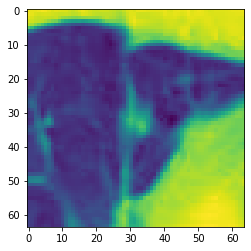

In [194]:
img = Image.open(cohort + "img_LIDC-IDRI-0526_1_59.jpg")
plt.imshow(img)

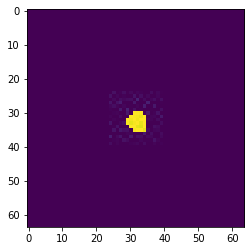

In [195]:
img = Image.open('/data/unet/val/masks/' + "mask_LIDC-IDRI-0526_1_59.jpg")
plt.imshow(img)

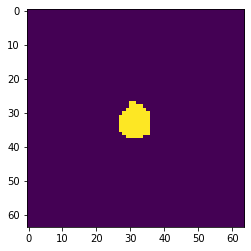

In [199]:
img = Image.open(cohort + "img_LIDC-IDRI-0526_1_59.jpg")
image = np.array(img).astype('float32')#vol[:,:,k_slice].astype('float32')
image -= np.mean(image)
image /= np.std(image)
image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
mask_pre = np.squeeze(mask_pre)
#  print(np.max(mask_pre), np.min(mask_pre))
#  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
mask_pre = np.where(mask_pre>0.5, 1,0)
plt.imshow(mask_pre)

In [ ]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    image = vol[:,:,k_slice].astype('float32')
    image -= np.mean(image)
    image /= np.std(image)
    image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
    mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    mask_pre = np.where(mask_pre>0.5, 1,0)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)